In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac
import read_load as rl

import exp_study_case
import exp_external_conditions
import exp_system_spec
import exp_house_spec
import exp_general_property
import exp_occupant_usage
import exp_circulating_air_flow
import exp_load

Importing Jupyter notebook from exp_study_case.ipynb
Importing Jupyter notebook from exp_external_conditions.ipynb
Importing Jupyter notebook from exp_system_spec.ipynb
Importing Jupyter notebook from exp_house_spec.ipynb
Importing Jupyter notebook from exp_general_property.ipynb
Importing Jupyter notebook from exp_occupant_usage.ipynb
Importing Jupyter notebook from exp_circulating_air_flow.ipynb
Importing Jupyter notebook from exp_load.ipynb


# 0. 検討ケース

試算するケースを取得します。

In [2]:
case = exp_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'default_heat_source_spec': True,
  'v_hs_rtd_h': 1800.0,
  'v_hs_rtd_c': 1800.0,
  'is_duct_insulated': True,
  'vav_system': False,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

1日グラフを描画する日を取得します。

In [3]:
hday, cday = exp_study_case.get_display_day()
hday, cday

('2/23', '9/1')

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール exp_system_spec を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [4]:
q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system = \
    exp_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])

q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system

(7733.9925600000015, 7664.646360000001, 1800.0, 1800.0, True, False)

### 住宅の仕様

外部モジュール exp_house_spec を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [5]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    exp_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール exp_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
「平日」「休日」の別

In [6]:
rho, c, l_wtr, calender = exp_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール exp_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [7]:
theta_ex, x_ex, h_ex, j, theta_sat = exp_external_conditions.get_external_conditions(case['region'])
theta_ex, x_ex, h_ex, j, theta_sat

(array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([72.52135498, 68.85197153, 69.34240102, ..., 67.88267058,
        69.83672797, 71.8536949 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]))

### 居住者の使い方

外部モジュール exp_occupant_usage を参照のこと。

暖冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿, g/h  
$V_{local,d,t}$：日付$d$時刻$t$における局所換気量, m<sup>3</sup>/h  
$V_{local,MR,d,t}$：日付$d$時刻$t$における主たる居室の局所換気量, m<sup>3</sup>/h  
$V_{local,OR,d,t}$：日付$d$時刻$t$におけるその他の居室の局所換気量, m<sup>3</sup>/h  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$\theta_{set,h}$：暖房時の設定温度, ℃  
$\theta_{set,c}$：冷房時の設定温度, ℃  
$X_{set,c}$：冷房時の設定絶対湿度, kg/kgDA  

In [8]:
hc_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c, x_set_c \
    = exp_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
hc_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c, x_set_c

(array(['h', 'h', 'h', ..., 'h', 'h', 'h'], dtype='<U1'),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 20.0,
 27.0,
 0.013425743)

### 循環風量

外部モジュール exp_circulating_air_flow を参照のこと。

$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [9]:
v_d_supply = exp_circulating_air_flow.get_circulating_air_flow(
    a_a, a_hcz, q, mu_h, mu_c, v_vent, theta_ex, x_ex, j, hc_period, n_p, q_gen, w_gen, v_local,
    theta_set_h, theta_set_c, x_set_c,
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c)
v_d_supply

array([[468.11565231, 460.46390045, 463.0144844 , ..., 416.81045706,
        430.28097496, 519.46598863],
       [260.04680316, 255.79611511, 257.21301113, ..., 231.54582922,
        239.02894818, 288.5728538 ],
       [208.06884915, 204.66778534, 205.80147328, ..., 185.26462785,
        191.25202678, 230.89313483],
       [168.96760882, 166.20568832, 167.12632849, ..., 150.44886005,
        155.31107986, 187.50265138],
       [169.12464191, 166.36015458, 167.28165035, ..., 150.58868241,
        155.45542101, 187.67691035]])

### 暖冷房負荷

外部モジュール exp_load を参照のこと。

$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$X_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の絶対湿度, kg/kgDA  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$X'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の絶対湿度, kg/kgDA  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  

In [10]:
theta_ac, x_ac, theta_d_nac, x_d_nac, l_d_h, l_d_cs, l_d_cl = exp_load.get_load(
    case['region'], case['house'], hc_period, theta_ex, x_ex, theta_set_h, theta_set_c, x_set_c,
    q, a_nr, v_local_nr, v_d_supply, u_prt, a_prt)
theta_ac, x_ac, theta_d_nac, x_d_nac, l_d_h, l_d_cs, l_d_cl

(array([20., 20., 20., ..., 20., 20., 20.]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([18.22650001, 18.21220063, 18.21209577, ..., 18.26895061,
        17.59949068, 18.40234349]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([[6.23047304, 6.18962515, 6.21026632, ..., 4.85221981, 6.20658233,
         6.20986372],
        [2.71332481, 2.70425677, 2.71106952, ..., 2.52805602, 2.78206175,
         2.68936914],
        [1.78903631, 1.77070826, 1.77257646, ..., 2.11568816, 1.88899629,
         1.77185517],
        [1.6671682 , 1.65175372, 1.6561385 , ..., 1.13881471, 1.69095636,
         1.64532273],
        [2.07205052, 2.05445792, 2.05877271, ..., 1.55268147, 2.08076081,
         2.04792201]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[-0., -0., -0., ..., -0., -0., -0.],
    

## 2. 運転状態

ダクト損失や非居室における熱の授受はシステムの運転中にしか発生しないものとする。運転中の判断は、全ての居室（$i=1～5$）においていずれかの部屋で負荷（暖房負荷又は顕熱冷房負荷）が発生している場合に運転中とする。つまり、  
$ \sum_{i=1}^5{L'_h} > 0 $ の場合は「暖房運転中」、  
$ \sum_{i=1}^5{L'_cs} > 0 $ の場合は「冷房運転中」、  
それ以外の場合は「運転停止中」とする。

$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  


In [11]:
operation = cs.get_operation(l_d_h, l_d_cs)

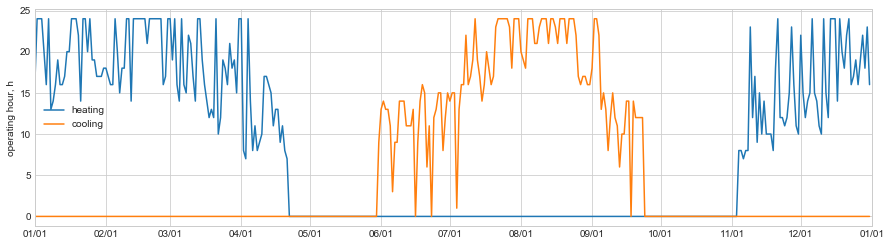

In [12]:
ac.draw_graph(y_title='operating hour, h', ys=[
        (operation == 'h', 'heating'),
        (operation == 'c', 'cooling'),
    ], op='itg')

## 3. ダクトおよびダクト周囲温度

### 線熱損失係数

ダクト $i$ の線熱損失係数 $\psi_i$ は、0.49 W/mK とする。

In [13]:
psi = cs.get_duct_linear_heat_loss_coefficient()
psi

0.49

### 標準住戸におけるダクト長さ

標準住戸における断熱区画内を通るダクト $i$ の長さ $l_{duct,in,R,i}$ 、標準住戸における断熱区画外を通るダクト $i$ の長さ $l_{duct,ex,R,i}$ 及び標準住戸におけるダクト $i$ の長さ $l_{duct,R,i}$ は下表の値とする。

| ダクトの長さ, m | 断熱区画1 | 断熱区画2 | 断熱区画3 | 断熱区画4 | 断熱区画5 |
| --- | --- | --- | --- | --- | --- |
| 断熱区画内 | 25.6 | 8.6 | 0.0 | 0.0 | 0.0 |
| 断熱区画外 | 0.0 | 0.0 | 10.2 | 11.8 | 8.1 |
| 合計 | 25.6 | 8.6 | 10.2 | 11.8 | 8.1 |

In [14]:
l_duct_in_r, l_duct_ex_r, l_duct_r = cs.get_standard_house_duct_length()

In [15]:
l_duct_in_r

array([25.6,  8.6,  0. ,  0. ,  0. ])

In [16]:
l_duct_ex_r

array([ 0. ,  0. , 10.2, 11.8,  8.1])

In [17]:
l_duct_r

array([25.6,  8.6, 10.2, 11.8,  8.1])

### 当該住戸のダクト長さ（合計）

ダクト $i$ の長さ $l_{duct,i}$ は次式により表される。

$$ l_{duct,i} = l_{duct,R,i} \sqrt{ \frac{A_A}{A_{A,R}} } $$

$l_{duct,i}$：ダクト$i$の長さ, m  
$l_{duct,R,i}$：標準住戸におけるダクト $i$ の長さ, m  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{A,R}$：標準住戸の床面積の合計, m  

In [18]:
l_duct = cs.get_duct_length(l_duct_r=l_duct_r, a_a=case['house']['a_a'])
l_duct

array([25.6,  8.6, 10.2, 11.8,  8.1])

#### 床面積の合計とダクト長さの関係

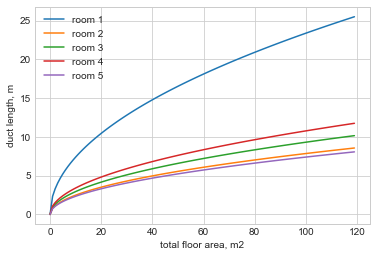

In [19]:
xs = np.arange(120)

def get_duct_length_each_room(room_number):
    return [cs.get_duct_length(l_duct_r=l_duct_r, a_a=x)[room_number] for x in xs]

plt.style.use('seaborn-whitegrid')

fig = plt.figure()

ax = fig.subplots()

ax.plot(xs, get_duct_length_each_room(0), label='room 1')
ax.plot(xs, get_duct_length_each_room(1), label='room 2')
ax.plot(xs, get_duct_length_each_room(2), label='room 3')
ax.plot(xs, get_duct_length_each_room(3), label='room 4')
ax.plot(xs, get_duct_length_each_room(4), label='room 5')

ax.set_xlabel('total floor area, m2')
ax.set_ylabel('duct length, m')

plt.legend()
plt.show()

### 小屋裏温度

$$\theta_{attic,d,t} = \theta_{SAT,d,t} H + \theta_{ac,d,t} ( 1 - H )$$

$\theta_{attic,d,t}$：日付 $d$ の時刻 $t$ における小屋裏の温度, ℃  
$\theta_{SAT,d,t}$：日付 $d$ の時刻 $t$ における水平面における等価外気温度, ℃  
$H$：温度差係数  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  

温度差係数 $H$ は、1.0とする。

In [20]:
theta_attic = cs.get_attic_temperature(theta_sat, theta_ac)

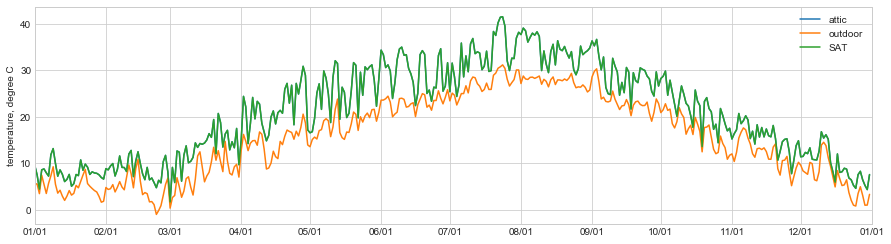

In [21]:
ac.draw_graph(y_title='temperature, degree C', ys=[(theta_attic, 'attic'),(theta_ex, 'outdoor'),(theta_sat, 'SAT')], op='ave')

### ダクト周囲空気温度

日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度 $\theta_{sur,d,t,i}$ はダクトの全部または一部が断熱区画外にある場合は下式によるものとし、それ意外の場合、暖冷房区画の温度 $\theta_{ac}$ に等しいとする。

$$ \theta_{sur,d,t,i} = \frac{ l_{duct,in,R,i} \theta_{ac} + l_{duct,ex,R,i} \theta_{attic,d,t} }{ l_{duct,in,R,i} + l_{duct,ex,R,i} } $$

$\theta_{sur,d,t,i}$：日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度, ℃  
$\theta_{ac}$：暖冷房区画の温度, ℃  
$l_{duct,in,R,i}$：標準住戸における断熱区画内を通るダクト $i$ の長さ, m  
$l_{duct,ex,R,i}$：標準住戸における断熱区画外を通るダクト $i$ の長さ, m  
$\theta_{attic,d,t}$：日付 $d$ の時刻 $t$ における小屋裏の温度, ℃  

In [22]:
theta_sur = cs.get_duct_ambient_air_temperature(case['system']['is_duct_insulated'], l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

#### ダクトが全て断熱区画内の場合のサンプル

In [23]:
theta_sur_sample_insulated = cs.get_duct_ambient_air_temperature(True, l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

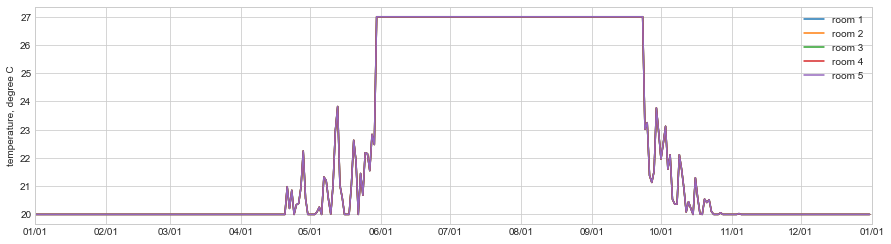

In [24]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_sample_insulated[0], 'room 1'),
                  (theta_sur_sample_insulated[1], 'room 2'),
                  (theta_sur_sample_insulated[2], 'room 3'),
                  (theta_sur_sample_insulated[3], 'room 4'),
                  (theta_sur_sample_insulated[4], 'room 5')], op='ave')

#### ダクトが全て断熱区画内ではない場合のサンプル

In [25]:
theta_sur_sample_not_insulated = cs.get_duct_ambient_air_temperature(False, l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

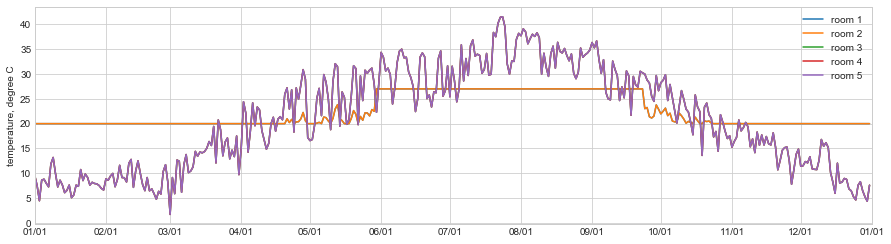

In [26]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_sample_not_insulated[0], 'room 1'),
                  (theta_sur_sample_not_insulated[1], 'room 2'),
                  (theta_sur_sample_not_insulated[2], 'room 3'),
                  (theta_sur_sample_not_insulated[3], 'room 4'),
                  (theta_sur_sample_not_insulated[4], 'room 5')], op='ave')

## 4. 最大出力時の熱源機出口温湿度

### 熱源機の入口空気温度

$$ \theta'_{hs,in,d,t} = \theta'_{nac,d,t} $$

$$X'_{hs,in,d,t} = X'_{nac,d,t} $$

$\theta'_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の熱源機の入口空気温度, ℃  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$X'_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の熱源機の入口空気絶対湿度, kg/kgDA  
$X'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の絶対湿度, kg/kgDA  

In [27]:
theta_d_hs_in, x_d_hs_in = cs.get_heat_source_inlet_air_balanced(theta_d_nac, x_d_nac)

### 熱源機の最大出力

暖房

$$ Q_{hs,max,H,d,t} = q_{rtd,H} C_{df,H,d,t} \times 3600 \times 10^{-6} $$

$Q_{hs,max,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大暖房出力, MJ/h  
$q_{rtd,H}$：定格暖房能力, W  
$C_{df,H,d,t}$：日付 $d$ の時刻 $t$ におけるデフロストに関する暖房出力補正係数  

日付 $d$ の時刻tにおけるデフロストに関する暖房出力補正係数 $C_{df,H,d,t}$ は、外気温度が5℃未満かつ相対湿度が80％以上の場合にデフロストが入ると仮定し、その場合の値を0.77とし、 それ以外の条件においては1.0とする。

In [28]:
q_hs_max_h = cs.get_heat_source_maximum_heating_output(case['region'], q_rtd_h)

冷房

本来であればSHFは非居室における顕・潜熱取得も考慮して決定する必要があるが、処理熱量が決まらないと非居室の温湿度が決まらず、非居室における顕・潜熱取得量も決まらない等、収束計算が発生し、計算ロジックが極めて複雑になるため、ここでは居室の顕・潜熱負荷のみからSHFを決定する。

$$ L'_{CS,d,t} = \sum_{i=1}^5{L'_{CS,d,t,i}} $$

$$ L'_{CL,d,t} = \sum_{i=1}^5{L'_{CL,d,t,i}} $$

$$ SHF_{L,min,C} = 0.4 $$

$$ L_{max,CL,d,t} = L'_{CS,d,t} \frac{ 1 - SHF_{L,min,C} }{ SHF_{L,min,C} } $$

$$ L''_{CL,d,t} = \min { \left( L_{max,CL,d,t}, L'_{CL,d,t} \right) } $$

$$ L''_{C,d,t} = L'_{CS,d,t} + L''_{CL,d,t} $$

$$ SHF'_{d,t} = \frac{ L'_{CS,d,t} }{ L''_{C,d,t} } $$

ただし、日付 $d$ の時刻 $t$ における1時間当たりの補正冷房負荷 $L''_{C,d,t}$ が0の場合、 $ SHF'_{d,t} = 0 $ とする。

$$ Q_{hs,max,C,d,t} = q_{rtd,C} \times 3600 \times 10^{-6} $$

$$ Q_{hs,max,CS,d,t} = Q_{hs,max,C,d,t} SHF'_{d,t} $$

$$ Q_{hs,max,CL,d,t} = \min { \left( Q_{hs,max,C,d,t} \left( 1 - SHF'_{d,t} \right), L''_{CL,d,t} \right) } $$


$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$L'_{CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$SHF_{L,min,C}$：冷房負荷最小顕熱比  
$L_{max,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの最大冷房潜熱負荷, MJ/h  
$L''_{CL,d,t}$：日付 $d$ の時刻 $t$ における１時間当たりの補正冷房潜熱負荷, MJ/h  
$L''_{C,d,t}$：日付 $d$ の時刻 $t$ における１時間当たりの補正冷房負荷, MJ/h  
$SHF'_{d,t}$：日付 $d$ の時刻 $t$ における冷房負荷補正顕熱比  
$Q_{hs,max,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房顕熱出力, MJ/h  
$Q_{hs,max,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房潜熱出力, MJ/h  
$Q_{hs,max,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房出力, MJ/h  
$q_{rtd,C}$：定格冷房能力, W  

In [29]:
q_hs_max_cs, q_hs_max_cl = cs.get_heat_source_maximum_cooling_output(q_rtd_c, l_d_cs, l_d_cl)

### 最大出力時の熱源機出口温湿度

暖房

$$ \theta_{hs,out,max,H,d,t} = \theta'_{hs,in,d,t} + \frac{ Q_{hs,max,H,d,t} }{ c \rho \sum_{i=1}^5{V'_{supply,d,t,i}} } \times 10^6 $$

ただし、$ \theta_{hs,out,max,H,d,t} > 45 $ の場合、$ \theta_{hs,out,max,H,d,t} = 45 $ とする。

冷房（顕熱）

$$ \theta_{hs,out,min,C,d,t} = \theta'_{hs,in,d,t} - \frac{ Q_{hs,max,CS,d,t} }{ c \rho \sum_{i=1}^5{V'_{supply,d,t,i}} } \times 10^6 $$

ただし、$ \theta_{hs,out,min,C,d,t} < 15 $ の場合、$ \theta_{hs,out,min,C,d,t} = 15 $ とする。

冷房（潜熱）

$$ X_{hs,out,min,C,d,t} = X'_{hs,in,d,t} - \frac{ Q_{hs,max,CL,d,t} }{ \rho L_{wtr} \sum_{i=1}^5{V'_{supply,d,t,i}} } \times 10^3 $$

$\theta_{hs,out,max,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度の最高値, ℃  
$\theta_{hs,out,min,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度の最低値, ℃  
$X_{hs,out,min,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気絶対湿度の最低値, kg/kgDA  
$\theta'_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の熱源機の入口空気温度, ℃  
$X'_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の熱源機の入口空気絶対湿度, kg/kgDA  
$Q_{hs,max,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大暖房出力, MJ/h  
$Q_{hs,max,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房顕熱出力, MJ/h  
$Q_{hs,max,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の最大冷房潜熱出力, MJ/h  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [30]:
theta_hs_out_max_h = cs.get_theta_hs_out_max_h(theta_d_hs_in, q_hs_max_h, v_d_supply)
theta_hs_out_min_c = cs.get_theta_hs_out_min_c(theta_d_hs_in, q_hs_max_cs, v_d_supply)
x_hs_out_min_c = cs.get_x_hs_out_min_c(x_d_hs_in, q_hs_max_cl, v_d_supply)

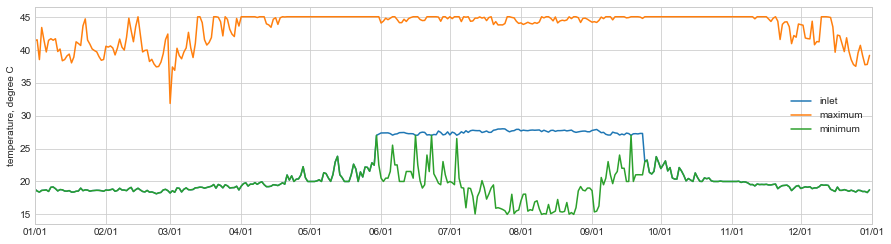

In [31]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[
                  (theta_d_hs_in, 'inlet'),
                  (theta_hs_out_max_h, 'maximum'),
                  (theta_hs_out_min_c, 'minimum'),
                 ], op='ave')

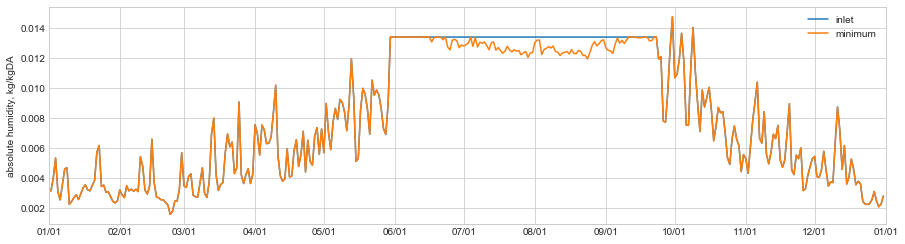

In [32]:
ac.draw_graph(y_title='absolute humidity, kg/kgDA',
              ys=[
                  (x_d_hs_in, 'inlet'),
                  (x_hs_out_min_c, 'minimum'),
                 ], op='ave')

## 5. 熱源機の要求出口空気温湿度

$$ \theta_{req,H,d,t,i} = \theta_{sur,H,d,t,i} + \left( \theta_{ac,d,t} + \frac{ L'_{H,d,t,i} \times 10^6 }{ V'_{supply,d,t,i} c \rho } - \theta_{sur,H,d,t,i} \right) \exp{ \left( \frac{ \psi_i l_{duct,i} \times 3600 }{ V'_{supply,d,t,i} c \rho } \right) } $$

$$ \theta_{req,C,d,t,i} = \theta_{sur,C,d,t,i} - \left( \theta_{sur,C,d,t,i} - \theta_{ac,d,t} + \frac{ L'_{CS,d,t,i} \times 10^6 }{ V'_{supply,d,t,i} c \rho } \right) \exp{ \left( \frac{ \psi_i l_{duct,i} \times 3600 }{ V'_{supply,d,t,i} c \rho } \right) } $$

$$ X_{req,C,d,t,i} = X_{ac,d,t} - \frac{ L'_{CL,d,t,i} \times 10^3 }{ V'_{supply,d,t,i} \rho L_{wtr} } $$

ただし  
$\theta_{req,H,d,t,i}$ が $\theta_{ac,d,t}$ を下回る場合は、$\theta_{req,H,d,t,i}$ は $\theta_{ac,d,t}$ に等しいとする。  
$\theta_{req,C,d,t,i}$ が $\theta_{ac,d,t}$ を上回る場合は、$\theta_{req,C,d,t,i}$ は $\theta_{ac,d,t}$ に等しいとする。  

$\theta_{req,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房空間 $i$ における熱源機の要求出口空気温度, ℃  
$\theta_{req,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房空間 $i$ における熱源機の要求出口空気温度, ℃  
$X_{req,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房空間 $i$ における熱源機の要求出口空気絶対湿度, kg/kgDA  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$X_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の絶対湿度, kg/kgDA  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  

In [33]:
theta_req_h = cs.get_requested_supply_air_temperature_for_heating(theta_sur, theta_ac, l_d_h, v_d_supply, psi, l_duct)
theta_req_c = cs.get_requested_supply_air_temperature_for_cooling(theta_sur, theta_ac, l_d_cs, v_d_supply, psi, l_duct)
x_req_c = cs.get_requested_supply_air_absolute_humidity_for_cooling(x_ac, l_d_cl, v_d_supply)

## 6. 熱源機の出口温度

VAVの機構を有する場合

$$ \theta_{hs,out,H,d,t} = \max_{i=1\sim5}⁡( \theta_{req,H,d,t,i} ) $$

$$ \theta_{hs,out,C,d,t} = \min_{i=1\sim5}( \theta_{req,C,d,t,i} ) $$

VAVの機構を有しない場合

$$ \theta_{hs,out,H,d,t} = \frac{ \sum_{i=1\sim5}⁡( \theta_{req,H,d,t,i} V'_{supply,d,t,i} ) }{ \sum_{i=1\sim5}⁡ { V'_{supply,d,t,i} } } $$

$$ \theta_{hs,out,C,d,t} = \frac{ \sum_{i=1\sim5}( \theta_{req,C,d,t,i} V'_{supply,d,t,i} ) }{ \sum_{i=1\sim5}⁡ { V'_{supply,d,t,i} } } $$


ただし、VAVの機構の有無に関わらず、$\theta_{hs,out,H,d,t}$ が $\theta_{hs,out,max,H,d,t}$ を超える場合は、$\theta_{hs,out,H,d,t}$ は $\theta_{hs,out,max,H,d,t}$ に等しいとし、$\theta_{hs,out,C,d,t}$ が $\theta_{hs,out,min,C,d,t}$ を下回る場合は、$\theta_{hs,out,C,d,t}$ は $\theta_{hs,out,min,C,d,t}$ に等しいとする。  

$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{req,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房空間 $i$ における熱源機の要求出口空気温度, ℃  
$\theta_{req,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房空間 $i$ における熱源機の要求出口空気温度, ℃  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$\theta_{hs,out,max,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度の最高値, ℃  
$\theta_{hs,out,min,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度の最低値, ℃  

In [34]:
theta_hs_out_h_non = cs.get_decided_outlet_supply_air_temperature_for_heating(False, theta_req_h, v_d_supply, theta_hs_out_max_h)
theta_hs_out_h_vav = cs.get_decided_outlet_supply_air_temperature_for_heating(True, theta_req_h, v_d_supply, theta_hs_out_max_h)
theta_hs_out_c_non = cs.get_decided_outlet_supply_air_temperature_for_cooling(False, theta_req_c, v_d_supply, theta_hs_out_min_c)
theta_hs_out_c_vav = cs.get_decided_outlet_supply_air_temperature_for_cooling(True, theta_req_c, v_d_supply, theta_hs_out_min_c)

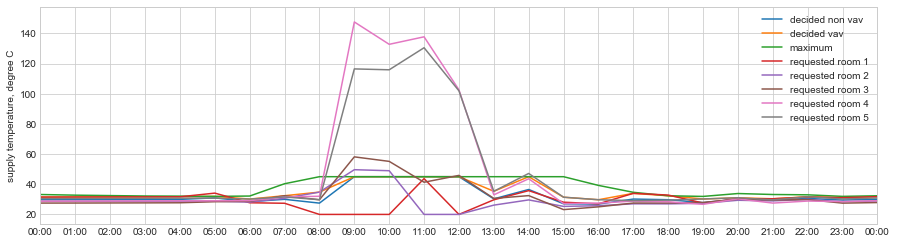

In [35]:
ac.draw_graph(y_title='supply temperature, degree C',
              ys=[(theta_hs_out_h_non, 'decided non vav'),
                  (theta_hs_out_h_vav, 'decided vav'),
                  (theta_hs_out_max_h, 'maximum'),
                  (theta_req_h[0], 'requested room 1'),
                  (theta_req_h[1], 'requested room 2'),
                  (theta_req_h[2], 'requested room 3'),
                  (theta_req_h[3], 'requested room 4'),
                  (theta_req_h[4], 'requested room 5')],
              op='raw', display_date=hday)

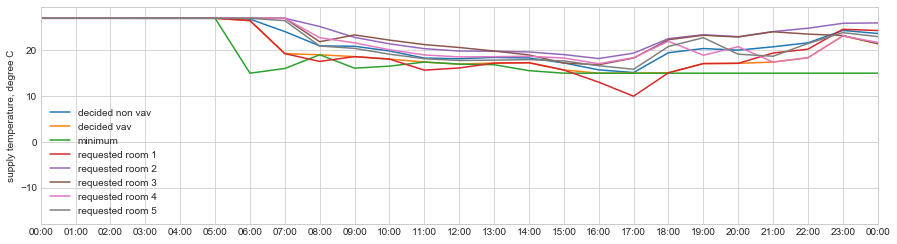

In [36]:
ac.draw_graph(y_title='supply temperature, degree C',
              ys=[(theta_hs_out_c_non, 'decided non vav'),
                  (theta_hs_out_c_vav, 'decided vav'),
                  (theta_hs_out_min_c, 'minimum'),
                  (theta_req_c[0], 'requested room 1'),
                  (theta_req_c[1], 'requested room 2'),
                  (theta_req_c[2], 'requested room 3'),
                  (theta_req_c[3], 'requested room 4'),
                  (theta_req_c[4], 'requested room 5')],
              op='raw', display_date=cday)

## 7. 各室への供給風量の決定

VAVの機構を有する場合、熱源機出口温度は各室の要求温度の最高値（暖房時）又は最低値（冷房時）になっているため、暖冷房空間によっては過剰供給になっている場合がある。  
VAVの機構を有する場合は各暖冷房空間の負荷に応じてダンパー等で風量を絞ることによって過剰供給にならないようにすることができる。  
ここでは、その計算を行う。

暖房期

$ V_{supply,d,t,i} $ は、VAVの機構の有無に応じて以下のように求まるとする。
ただし、VAVの機構の有無に関わらず、「運転停止中」では、$V_{supply,d,t,i}$ は $V_{vent,i}$ に等しいとする。  

VAVの機構を有する場合

$$ V_{supply,d,t,i} = \frac{ L'_{H,d,t,i} \times 10^6 + ( \theta_{hs,out,H,d,t} - \theta_{sur,H,d,t,i} ) \psi_i l_{duct,i} \times 3600 }{ c \rho ( \theta_{hs,out,H,d,t} - \theta_{ac} ) } $$

ただし、上限値 $V'_{supply,d,t,i}$ 及び、下限値 $V_{vent,i}$ とする。また、$\theta_{hs,out,H,d,t} \le \theta_{ac}$ の場合、$V_{supply,d,t,i}$ は $V_{vent,i}$ に等しいとする。

VAVの機構を有しない場合

$$ V_{supply,d,t,i} = V'_{supply,d,t,i} $$  

冷房期

$ V_{supply,d,t,i} $ は、VAVの機構の有無に応じて以下のように求まるとする。
ただし、VAVの機構の有無に関わらず、「運転停止中」では、$V_{supply,d,t,i}$ は $V_{vent,i}$ に等しいとする。  

VAVの機構を有する場合

$$ V_{supply,d,t,i} = \frac{ L'_{CS,d,t,i} \times 10^6 + ( \theta_{sur,C,d,t,i} - \theta_{hs,out,C,d,t} ) \psi_i l_{duct,i} \times 3600 }{ c \rho ( \theta_{ac} - \theta_{hs,out,C,d,t} ) } $$

ただし、上限値 $V'_{supply,d,t,i}$ 及び、下限値 $V_{vent,i}$ とする。また、$\theta_{hs,out,C,d,t} \ge \theta_{ac}$ の場合、$V_{supply,d,t,i}$ は $V_{vent,i}$ に等しいとする。

VAVの機構を有しない場合

$$ V_{supply,d,t,i} = V'_{supply,d,t,i} $$

中間期

$$ V_{supply,d,t,i} = V_{vent,i} $$

$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [37]:
v_supply_non = cs.get_each_supply_air_volume(
    hc_period, False, l_d_h, l_d_cs, theta_hs_out_h_non, theta_hs_out_c_non, theta_sur,
    psi, l_duct, theta_ac, v_vent, v_d_supply, operation)
v_supply_vav = cs.get_each_supply_air_volume(
    hc_period, True, l_d_h, l_d_cs, theta_hs_out_h_vav, theta_hs_out_c_vav, theta_sur,
    psi, l_duct, theta_ac, v_vent, v_d_supply, operation)

In [38]:
def draw_v_supply_sample_graph(rn, display_date):
    ac.draw_graph(y_title='supply air volume m3/h',
                  ys=[(v_d_supply[rn], 'designed'),
                      (v_supply_non[rn], 'non vav'),
                      (v_supply_vav[rn], 'vav')],
                  op='raw', display_date=display_date)

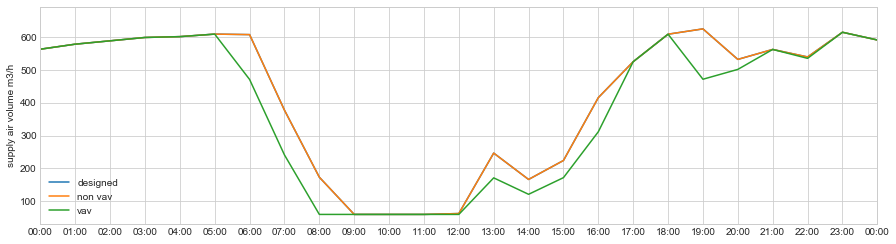

In [39]:
draw_v_supply_sample_graph(0, hday)

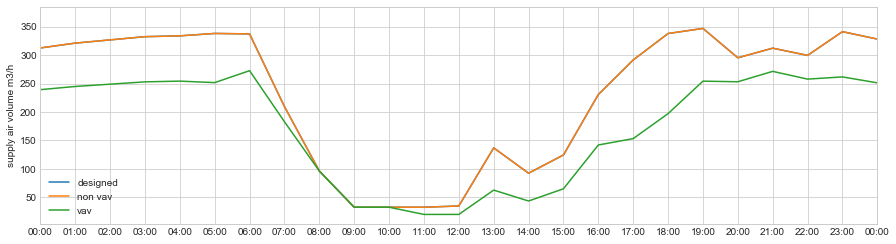

In [40]:
draw_v_supply_sample_graph(1, hday)

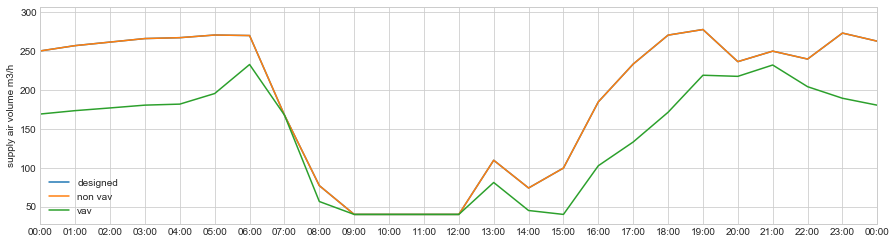

In [41]:
draw_v_supply_sample_graph(2, hday)

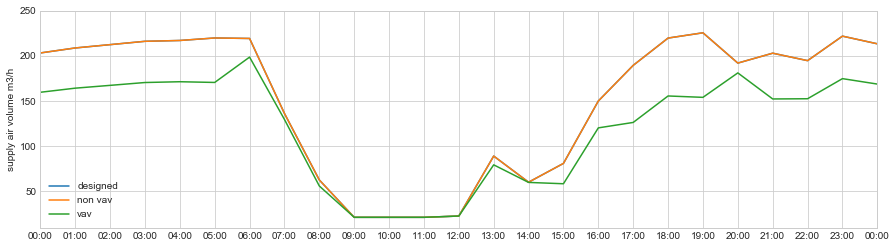

In [42]:
draw_v_supply_sample_graph(3, hday)

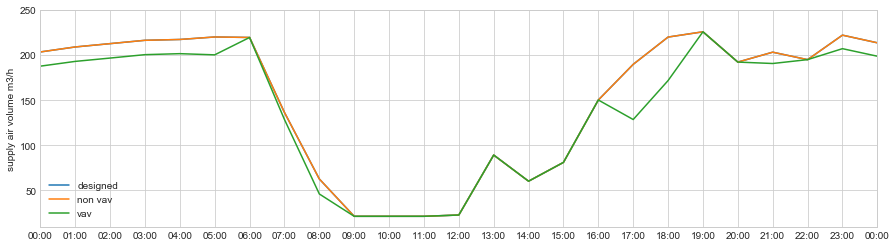

In [43]:
draw_v_supply_sample_graph(4, hday)

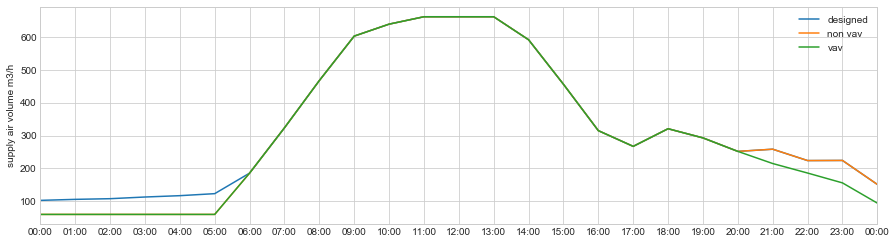

In [44]:
draw_v_supply_sample_graph(0, cday)

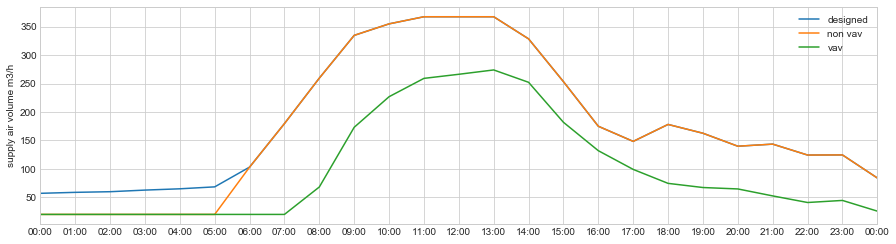

In [45]:
draw_v_supply_sample_graph(1, cday)

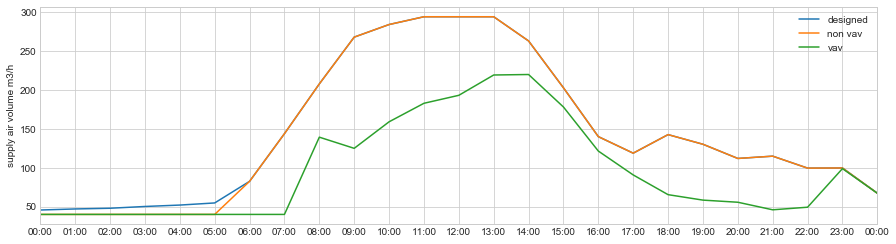

In [46]:
draw_v_supply_sample_graph(2, cday)

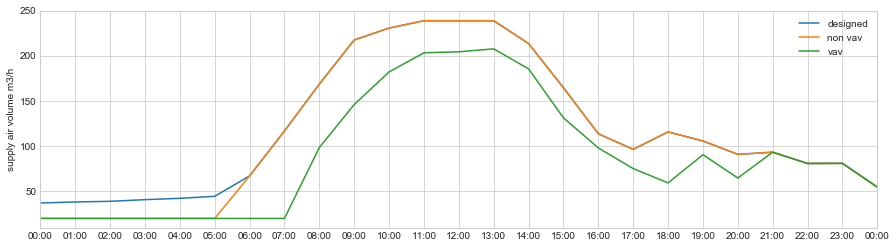

In [47]:
draw_v_supply_sample_graph(3, cday)

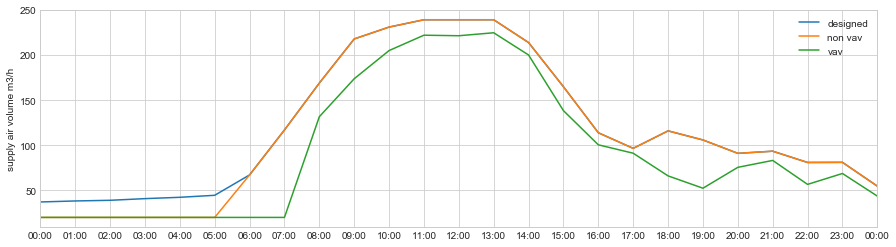

In [48]:
draw_v_supply_sample_graph(4, cday)

## 7. 熱源機の出口絶対湿度

$$ X_{hs,out,C,d,t} = \frac{ \sum_{i=1\sim5}( X_{req,C,d,t,i} V_{supply,d,t,i} ) }{ \sum_{i=1\sim5}⁡ { V_{supply,d,t,i} } } $$

ただし、$X_{hs,out,C,d,t}$ が $X_{hs,out,min,C,d,t}$ を下回る場合は、$X_{hs,out,C,d,t}$ は$X_{hs,out,min,C,d,t}$ に等しいとする。  

$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気絶対湿度, kg/kgDA  
$X_{req,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房室 $i$ における熱源機の要求出口空気絶対湿度, kg/kgDA  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ への吹き出し風量, m<sup>3</sup>/h  
$X_{hs,out,min,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気絶対湿度の最低値, kg/kgDA  

In [49]:
x_hs_out_c_non = cs.get_decided_outlet_supply_air_absolute_humidity_for_cooling(x_req_c, v_supply_non, x_hs_out_min_c)
x_hs_out_c_vav = cs.get_decided_outlet_supply_air_absolute_humidity_for_cooling(x_req_c, v_supply_vav, x_hs_out_min_c)

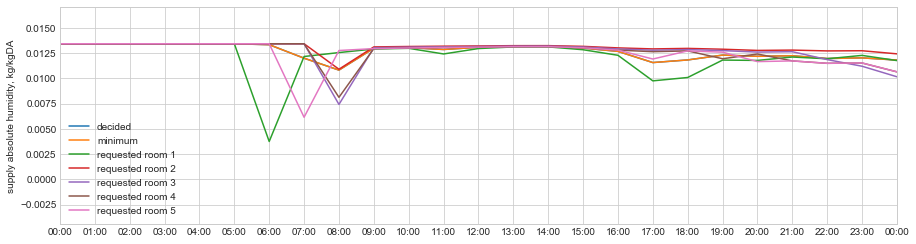

In [50]:
ac.draw_graph(y_title='supply absolute humidity, kg/kgDA', ys=[
    (x_hs_out_c_non, 'decided'),
    (x_hs_out_min_c, 'minimum'),
    (x_req_c[0], 'requested room 1'),
    (x_req_c[1], 'requested room 2'),
    (x_req_c[2], 'requested room 3'),
    (x_req_c[3], 'requested room 4'),
    (x_req_c[4], 'requested room 5')
], op='raw', display_date=cday)

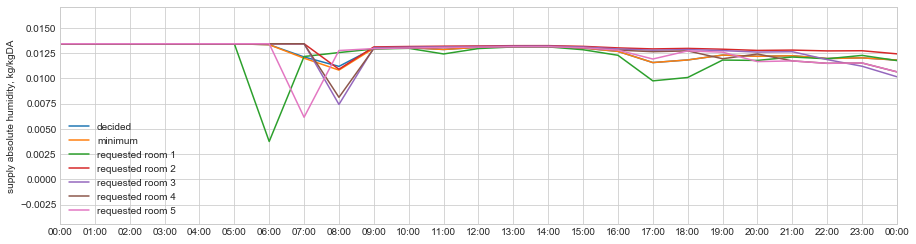

In [51]:
ac.draw_graph(y_title='supply absolute humidity, kg/kgDA', ys=[
    (x_hs_out_c_vav, 'decided'),
    (x_hs_out_min_c, 'minimum'),
    (x_req_c[0], 'requested room 1'),
    (x_req_c[1], 'requested room 2'),
    (x_req_c[2], 'requested room 3'),
    (x_req_c[3], 'requested room 4'),
    (x_req_c[4], 'requested room 5')
], op='raw', display_date=cday)

## 8. ダクト熱損失（参考）

本項目は仕様書に記載する必要はない。

暖房運転中

$$ Q_{duct,H,d,t,i} = \left( \theta_{hs,out,H,d,t} - \theta_{sur,H,d,t,i} \right) \left( 1 - \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,H,d,t,i} } \right) \right) c \rho V_{supply,H,d,t,i} 10^{-6} $$

$$ Q_{duct,C,d,t,i} = 0 $$

冷房運転中

$$ Q_{duct,H,d,t,i} =0 $$

$$ Q_{duct,C,d,t,i} = \left( \theta_{sur,C,d,t,i} - \theta_{hs,out,C,d,t} \right) \left( 1 - \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,C,d,t,i} } \right) \right) c \rho V_{supply,C,d,t,i} 10^{-6} $$

運転停止中

$$ Q_{duct,H,d,t,i} =0 $$

$$ Q_{duct,C,d,t,i} = 0 $$

$Q_{duct,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の熱損失, MJ/h  
$Q_{duct,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の熱取得, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, ℃  
$\theta_{sur,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の周囲の空気温度, ℃  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$V_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時の暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  

In [52]:
q_loss_duct_h_non, q_gain_duct_c_non = cs.get_duct_heat_loss_and_gain(
    theta_sur, theta_hs_out_h_non, theta_hs_out_c_non, v_supply_non, psi, l_duct, operation)
q_loss_duct_h_vav, q_gain_duct_c_vav = cs.get_duct_heat_loss_and_gain(
    theta_sur, theta_hs_out_h_vav, theta_hs_out_c_vav, v_supply_vav, psi, l_duct, operation)

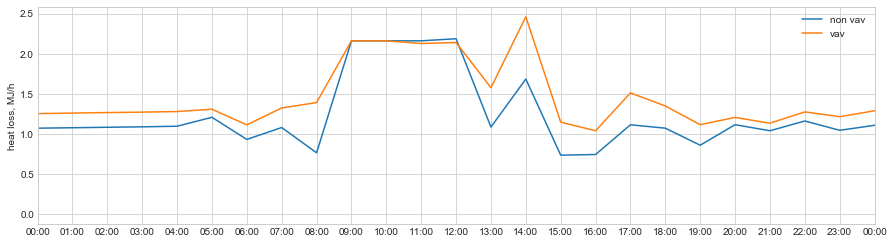

In [53]:
ac.draw_graph(y_title='heat loss, MJ/h',
                  ys=[(np.sum(q_loss_duct_h_non, axis=0), 'non vav'),
                      (np.sum(q_loss_duct_h_vav, axis=0), 'vav')],
                  op='raw', display_date=hday)

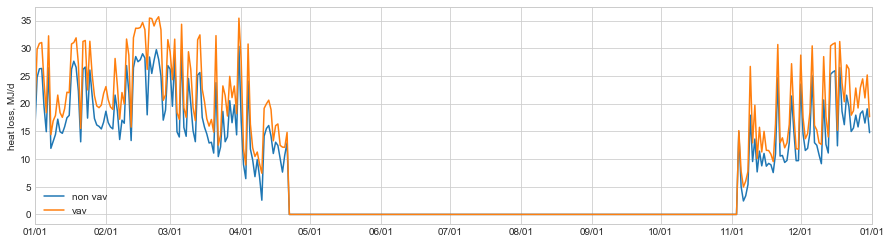

In [54]:
ac.draw_graph(y_title='heat loss, MJ/d',
                  ys=[(np.sum(q_loss_duct_h_non, axis=0), 'non vav'),
                      (np.sum(q_loss_duct_h_vav, axis=0), 'vav')],
                  op='itg')

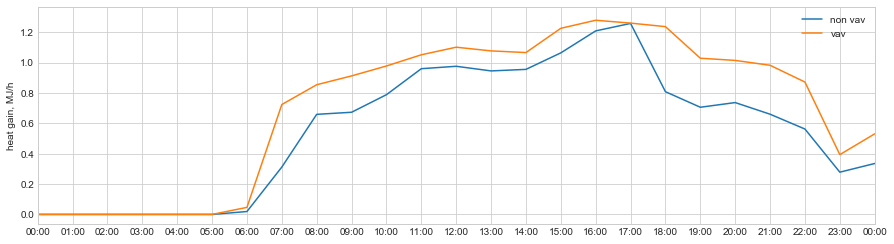

In [55]:
ac.draw_graph(y_title='heat gain, MJ/h',
                  ys=[(np.sum(q_gain_duct_c_non, axis=0), 'non vav'),
                      (np.sum(q_gain_duct_c_vav, axis=0), 'vav')],
                  op='raw', display_date=cday)

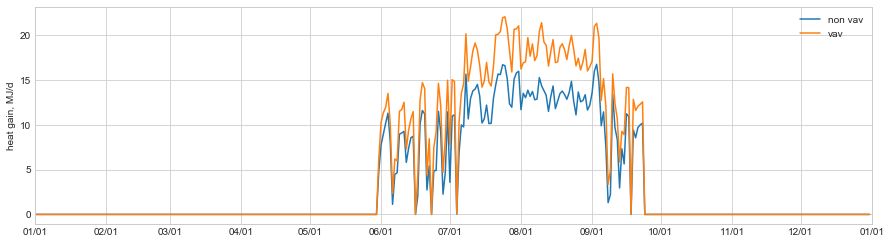

In [56]:
ac.draw_graph(y_title='heat gain, MJ/d',
                  ys=[(np.sum(q_gain_duct_c_non, axis=0), 'non vav'),
                      (np.sum(q_gain_duct_c_vav, axis=0), 'vav')],
                  op='itg')

## 9. 吹き出し温湿度

「暖房運転中」

$$ \theta_{supply,H,d,t,i} = \theta_{sur,d,t,i} + \left( \theta_{hs,out,H,d,t} - \theta_{sur,d,t,i} \right) \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,d,t,i} } \right) $$

「暖房運転中」以外

$$ \theta_{supply,H,d,t,i} = \theta_{ac,d,t} $$

「冷房運転中」

$$ \theta_{supply,C,d,t,i} = \theta_{sur,d,t,i} + \left( \theta_{hs,out,C,d,t} - \theta_{sur,d,t,i} \right) \exp \left( - \frac{ \psi_i l_{duct,i} \times 3600 }{ c \rho V_{supply,d,t,i} } \right) $$

$$ X_{supply,C,d,t,i} = X_{hs,out,C,d,t} $$

「冷房運転中」以外

$$ \theta_{supply,C,d,t,i} = \theta_{ac,d,t} $$

$$ X_{supply,C,d,t,i} = X_{ac,d,t} $$

$\theta_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し温度, ℃  
$X_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し絶対湿度, kg/kgDA  
$\theta_{sur,d,t,i}$：日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度, ℃  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気絶対湿度, kg/kgDA  
$\psi_i$：ダクト $i$ の線熱損失係数, W/mK  
$l_{duct,i}$：ダクト $i$ の長さ, m  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$X_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の絶対湿度, kg/kgDA  

In [57]:
theta_supply_h_non = cs.get_supply_air_temperature_for_heating(theta_sur, theta_hs_out_h_non, psi, l_duct, v_supply_non, theta_ac, operation)
theta_supply_h_vav = cs.get_supply_air_temperature_for_heating(theta_sur, theta_hs_out_h_vav, psi, l_duct, v_supply_vav, theta_ac, operation)
theta_supply_c_non = cs.get_supply_air_temperature_for_cooling(theta_sur, theta_hs_out_c_non, psi, l_duct, v_supply_non, theta_ac, operation)
theta_supply_c_vav = cs.get_supply_air_temperature_for_cooling(theta_sur, theta_hs_out_c_vav, psi, l_duct, v_supply_vav, theta_ac, operation)
x_supply_c_non = cs.get_supply_air_absolute_humidity_for_cooling(x_hs_out_c_non, x_ac, operation)
x_supply_c_vav = cs.get_supply_air_absolute_humidity_for_cooling(x_hs_out_c_vav, x_ac, operation)

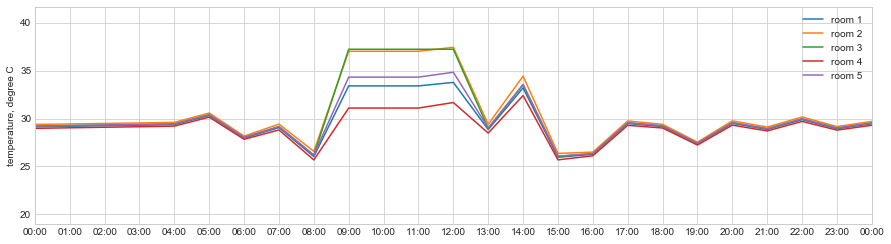

In [58]:
ac.draw_graph(y_title='temperature, degree C', ys=[
    (theta_supply_h_non[0], 'room 1'),
    (theta_supply_h_non[1], 'room 2'),
    (theta_supply_h_non[2], 'room 3'),
    (theta_supply_h_non[3], 'room 4'),
    (theta_supply_h_non[4], 'room 5'),
], op='raw', display_date=hday)

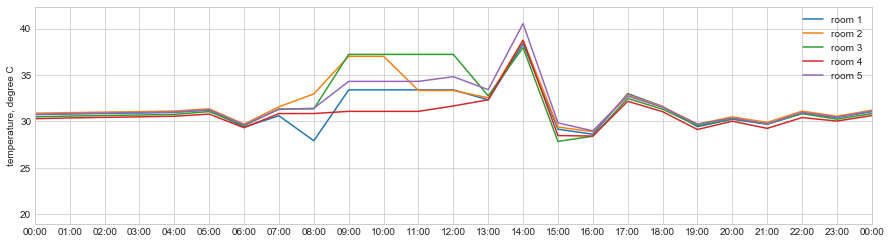

In [59]:
ac.draw_graph(y_title='temperature, degree C', ys=[
    (theta_supply_h_vav[0], 'room 1'),
    (theta_supply_h_vav[1], 'room 2'),
    (theta_supply_h_vav[2], 'room 3'),
    (theta_supply_h_vav[3], 'room 4'),
    (theta_supply_h_vav[4], 'room 5'),
], op='raw', display_date=hday)

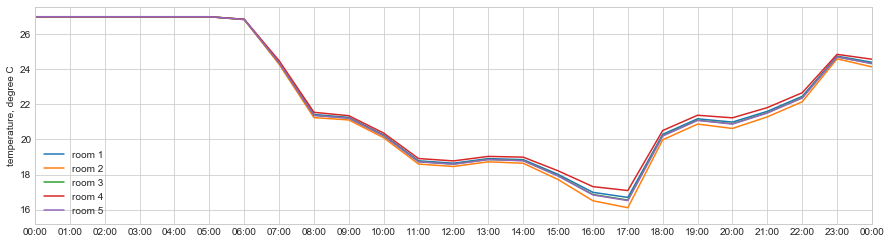

In [60]:
ac.draw_graph(y_title='temperature, degree C', ys=[
    (theta_supply_c_non[0], 'room 1'),
    (theta_supply_c_non[1], 'room 2'),
    (theta_supply_c_non[2], 'room 3'),
    (theta_supply_c_non[3], 'room 4'),
    (theta_supply_c_non[4], 'room 5'),
], op='raw', display_date=cday)

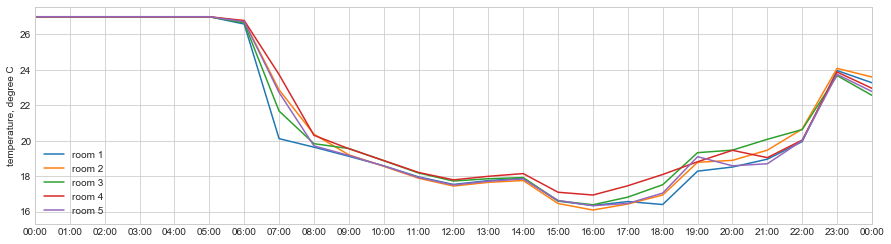

In [61]:
ac.draw_graph(y_title='temperature, degree C', ys=[
    (theta_supply_c_vav[0], 'room 1'),
    (theta_supply_c_vav[1], 'room 2'),
    (theta_supply_c_vav[2], 'room 3'),
    (theta_supply_c_vav[3], 'room 4'),
    (theta_supply_c_vav[4], 'room 5'),
], op='raw', display_date=cday)

## 10. 暖冷房室の実現温湿度

暖房期

$$ \theta_{ac,act,d,t,i} = \theta_{ac,d,t} + \frac{ c \rho V_{supply,d,t,i} \left( \theta_{supply,H,d,t,i} - \theta_{ac,d,t} \right) - L'_{H,d,t,i} \times 10^6 }{ c \rho V_{supply,d,t,i} + \left( U_{prt} A_{prt,i} + Q A_{HCZ,i} \right) \times 3600 } $$

ただし、$ \theta_{ac,act,d,t,i} $ が $ \theta_{ac,d,t} $ を下回る場合は、$ \theta_{ac,act,d,t,i} $ は $ \theta_{ac,d,t} $ に等しいとする。

冷房期

$$ \theta_{ac,act,d,t,i} = \theta_{ac,d,t} - \frac{ c \rho V_{supply,d,t,i} \left( \theta_{ac,d,t} - \theta_{supply,C,d,t,i} \right) - L'_{CS,d,t,i} \times 10^6 }{ c \rho V_{supply,d,t,i} + \left( U_{prt} A_{prt,i} + Q A_{HCZ,i} \right) \times 3600 } $$

ただし、$ \theta_{ac,act,d,t,i} $ が $ \theta_{ac,d,t} $ を上回る場合は、$ \theta_{ac,act,d,t,i} $ は $ \theta_{ac,d,t} $ に等しいとする。

中間期

$$ \theta_{ac,act,d,t,i} = \theta_{ac,d,t} $$

$$ X_{ac,act,d,t,i} = X_{ac,d,t} $$

$\theta_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現温度, ℃    
$X_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現絶対湿度, kg/kgDA    
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃    
$X_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の絶対湿度, kg/kgDA    
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
$\theta_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し温度, ℃  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$Q$：熱損失係数, W/m<sup>2</sup>K  

In [62]:
theta_ac_act_non = cs.get_actual_air_conditioned_temperature(
    hc_period, theta_ac, v_supply_non, theta_supply_h_non, theta_supply_c_non,
    l_d_h, l_d_cs, u_prt, a_prt, a_hcz, q)
theta_ac_act_vav = cs.get_actual_air_conditioned_temperature(
    hc_period, theta_ac, v_supply_vav, theta_supply_h_vav, theta_supply_c_vav,
    l_d_h, l_d_cs, u_prt, a_prt, a_hcz, q)
x_ac_act_non = cs.get_actual_air_conditioned_absolute_humidity(x_ac)
x_ac_act_vav = cs.get_actual_air_conditioned_absolute_humidity(x_ac)

In [63]:
def draw_theta_ac_act_h_sample_graph(rn):
    ac.draw_graph(y_title='temperature, degree C',
                  ys=[
                      (theta_ac_act_non[rn], 'non vav'),
                      (theta_ac_act_vav[rn], 'vav'),
                      (theta_ac, 'original'),
                  ],
                  op='raw', display_date=hday)

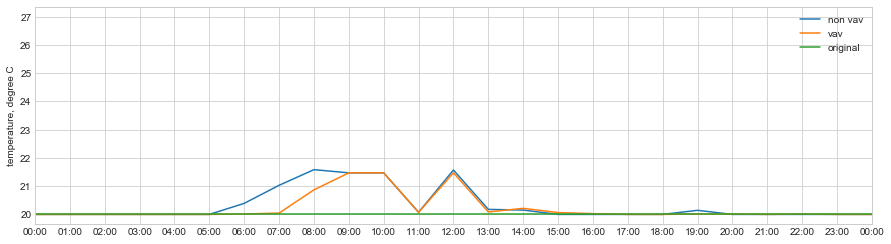

In [64]:
draw_theta_ac_act_h_sample_graph(0)

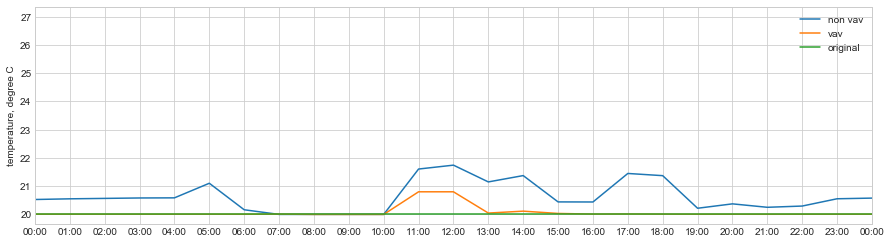

In [65]:
draw_theta_ac_act_h_sample_graph(1)

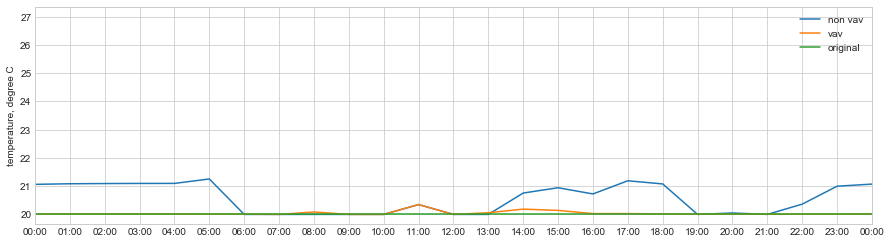

In [66]:
draw_theta_ac_act_h_sample_graph(2)

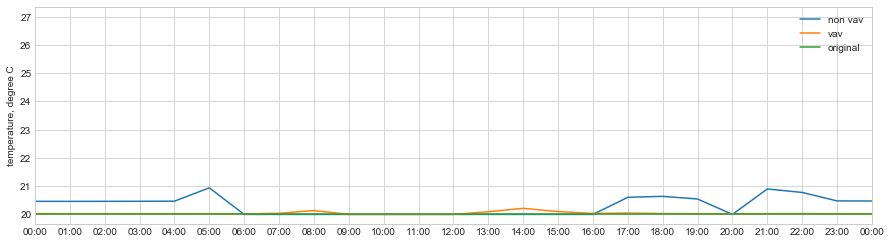

In [67]:
draw_theta_ac_act_h_sample_graph(3)

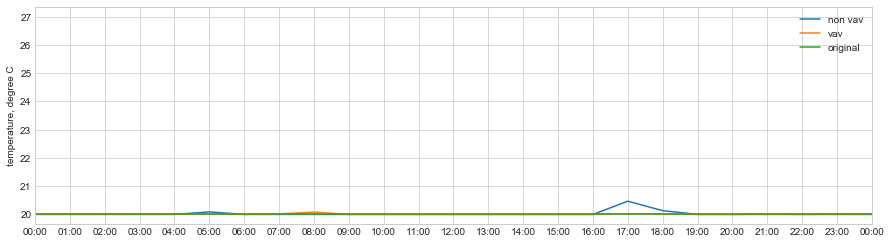

In [68]:
draw_theta_ac_act_h_sample_graph(4)

In [69]:
def draw_theta_ac_act_c_sample_graph(rn):
    ac.draw_graph(y_title='temperature, degree C', ys=[
        (theta_ac_act_non[rn], 'non vav'),
        (theta_ac_act_vav[rn], 'vav'),
        (theta_ac, 'original'),
    ], op='raw', display_date=cday)

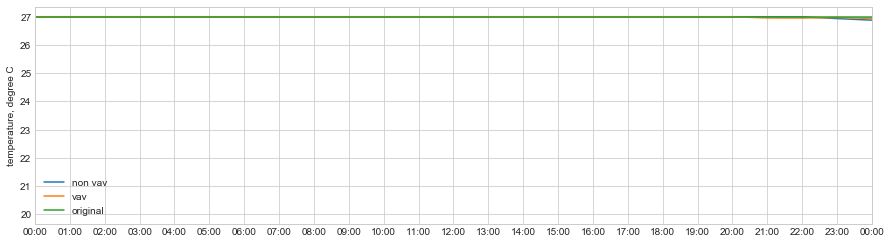

In [70]:
draw_theta_ac_act_c_sample_graph(0)

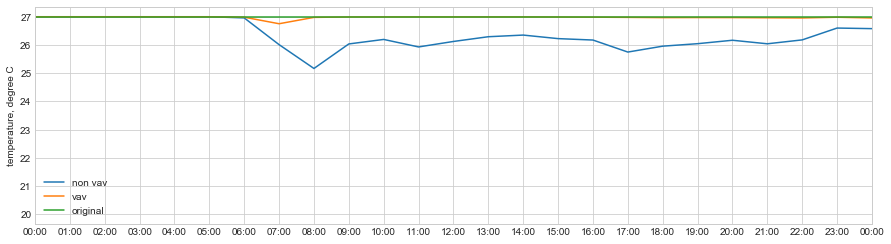

In [71]:
draw_theta_ac_act_c_sample_graph(1)

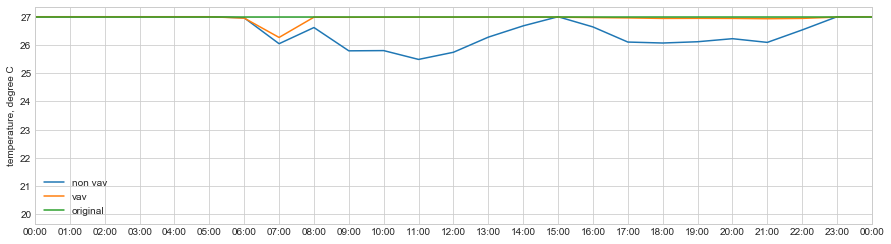

In [72]:
draw_theta_ac_act_c_sample_graph(2)

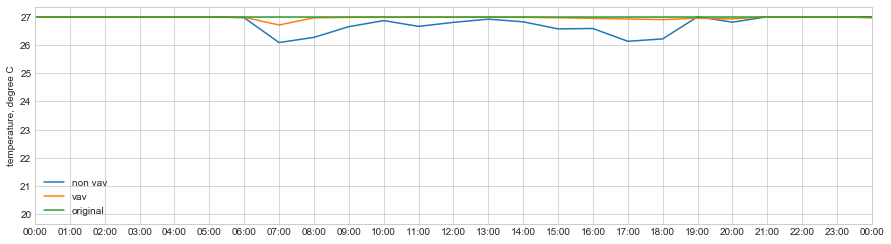

In [73]:
draw_theta_ac_act_c_sample_graph(3)

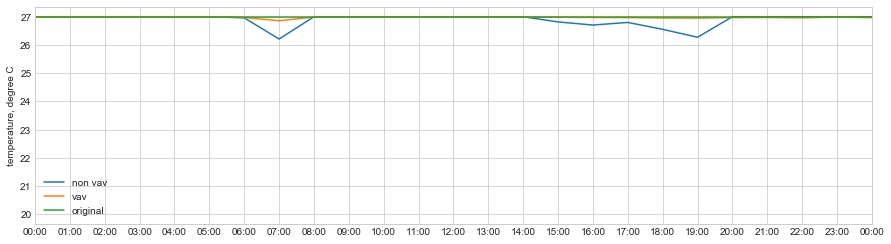

In [74]:
draw_theta_ac_act_c_sample_graph(4)

## 11. 暖冷房空間（居室）の負荷（間仕切りの熱移動を含む）

暖房期

$$ L'_{act,H,d,t,i} = \left( \theta_{supply,H,d,t,i} - \theta_{ac,act,d,t,i} \right) c \rho V_{supply,d,t,i} \times 10^{-6} $$

$$ L'_{act,CS,d,t,i} = 0.0 $$

$$ L'_{act,CL,d,t,i} = 0.0 $$

冷房期

$$ L'_{act,H,d,t,i} = 0.0 $$

$$ L'_{act,CS,d,t,i} = \left( \theta_{ac,act,d,t,i} - \theta_{supply,C,d,t,i} \right) c \rho V_{supply,d,t,i} \times 10^{-6} $$

$$ L'_{act,CL,d,t,i} = \left( X_{ac,act,d,t,i} - X_{supply,C,d,t,i} \right) L_{wtr} \rho V_{supply,d,t,i} \times 10^{-3} $$

中間期

$$ L'_{act,H,d,t,i} = 0.0 $$

$$ L'_{act,CS,d,t,i} = 0.0 $$

$$ L'_{act,CL,d,t,i} = 0.0 $$

$L'_{act,H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの間仕切り熱損失を含む実際の（※）暖房負荷, MJ/h  
$L'_{act,CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの間仕切り熱取得を含む実際の（※）顕熱冷房負荷, MJ/h  
$L'_{act,CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの実際の（※）潜熱冷房負荷, MJ/h  
$\theta_{supply,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の吹き出し温度, ℃  
$\theta_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し温度, ℃  
$X_{supply,C,d,t,i}$：日付 $d$ の時刻 $t$ における冷房時のダクト $i$ の吹き出し絶対湿度, kg/kgDA  
$\theta_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現温度, ℃    
$X_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現絶対湿度, kg/kgDA    
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$L_{wtr}$：水の蒸発潜熱, kgJ/kg  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
※ 実際の・・・過剰供給によって実現した温度が設定温度よりも高い（暖房時）又は低い（冷房時）影響を考慮した負荷

In [75]:
l_d_act_h_non = cs.get_actual_treated_heating_load(hc_period, theta_supply_h_non, theta_ac_act_non, v_supply_non)
l_d_act_h_vav = cs.get_actual_treated_heating_load(hc_period, theta_supply_h_vav, theta_ac_act_vav, v_supply_vav)
l_d_act_cs_non = cs.get_actual_treated_sensible_cooling_load(hc_period, theta_supply_c_non, theta_ac_act_non, v_supply_non)
l_d_act_cs_vav = cs.get_actual_treated_sensible_cooling_load(hc_period, theta_supply_c_vav, theta_ac_act_vav, v_supply_vav)
l_d_act_cl_non = cs.get_actual_treated_latent_cooling_load(hc_period, x_supply_c_non, x_ac_act_non, v_supply_non)
l_d_act_cl_vav = cs.get_actual_treated_latent_cooling_load(hc_period, x_supply_c_vav, x_ac_act_vav, v_supply_vav)

## 12. 未処理負荷

$$ Q_{UT,H,d,t,i} = \max \left( L'_{H,d,t,i} - L'_{act,H,d,t,i}, 0.0 \right) $$

$$ Q_{UT,CS,d,t,i} = \max \left( L'_{CS,d,t,i} - L'_{act,CS,d,t,i}, 0.0 \right) $$

$$ Q_{UT,CL,d,t,i} = \max \left( L'_{CL,d,t,i} - L'_{act,CL,d,t,i}, 0.0 \right) $$

$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の未処理暖房負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房顕熱負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房潜熱負荷, MJ/h  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$L'_{act,H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの間仕切り熱損失を含む実際の（※）暖房負荷, MJ/h  
$L'_{act,CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの間仕切り熱取得を含む実際の（※）顕熱冷房負荷, MJ/h  
$L'_{act,CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの実際の（※）潜熱冷房負荷, MJ/h  

In [76]:
q_ut_h_non, q_ut_cs_non, q_ut_cl_non = cs.get_untreated_load(l_d_act_h_non, l_d_h, l_d_act_cs_non, l_d_cs, l_d_act_cl_non, l_d_cl)
q_ut_h_vav, q_ut_cs_vav, q_ut_cl_vav = cs.get_untreated_load(l_d_act_h_vav, l_d_h, l_d_act_cs_vav, l_d_cs, l_d_act_cl_vav, l_d_cl)

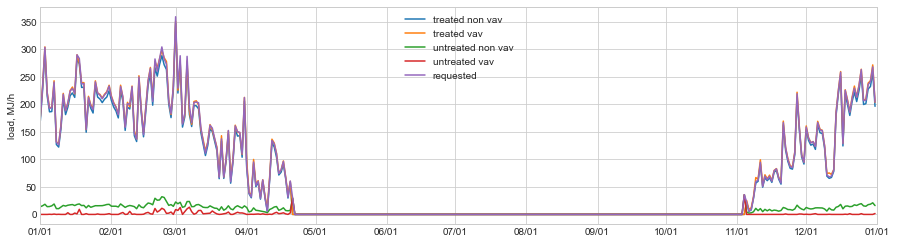

In [77]:
ac.draw_graph(y_title='load, MJ/h', ys=[
    (np.sum(l_d_act_h_non, axis=0), 'treated non vav'),
    (np.sum(l_d_act_h_vav, axis=0), 'treated vav'),
    (np.sum(q_ut_h_non, axis=0), 'untreated non vav'),
    (np.sum(q_ut_h_vav, axis=0), 'untreated vav'),
    (np.sum(l_d_h, axis=0), 'requested'),
], op='itg')

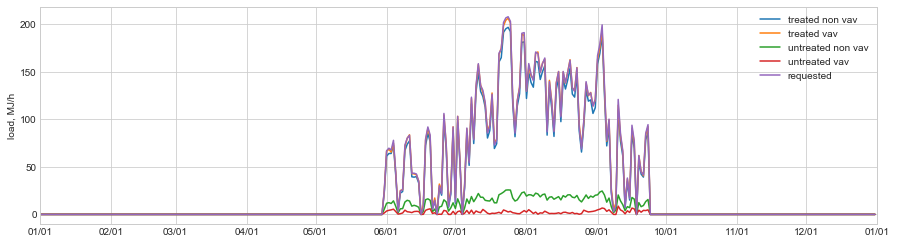

In [78]:
ac.draw_graph(y_title='load, MJ/h', ys=[
    (np.sum(l_d_act_cs_non, axis=0), 'treated non vav'),
    (np.sum(l_d_act_cs_vav, axis=0), 'treated vav'),
    (np.sum(q_ut_cs_non, axis=0), 'untreated non vav'),
    (np.sum(q_ut_cs_vav, axis=0), 'untreated vav'),
    (np.sum(l_d_cs, axis=0), 'requested'),
], op='itg')

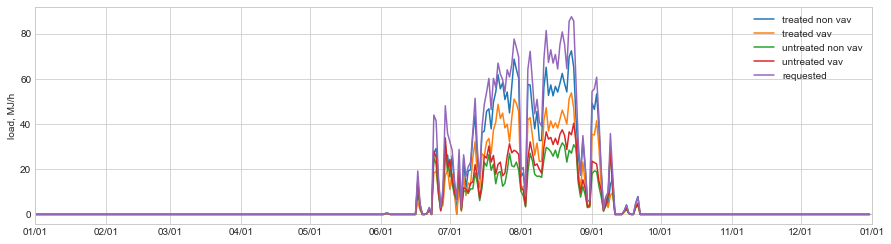

In [79]:
ac.draw_graph(y_title='load, MJ/h', ys=[
    (np.sum(l_d_act_cl_non, axis=0), 'treated non vav'),
    (np.sum(l_d_act_cl_vav, axis=0), 'treated vav'),
    (np.sum(q_ut_cl_non, axis=0), 'untreated non vav'),
    (np.sum(q_ut_cl_vav, axis=0), 'untreated vav'),
    (np.sum(l_d_cl, axis=0), 'requested')
], op='itg')

In [80]:
def draw_l_d_act_h_sample_graph(rn):
    ac.draw_graph(y_title='load, MJ/h', ys=[
        (l_d_act_h_non[rn], 'treated non vav'),
        (l_d_act_h_vav[rn], 'treated vav'),
        (q_ut_h_non[rn], 'untreated non vav'),
        (q_ut_h_vav[rn], 'untreated vav'),
        (l_d_h[rn], 'requested')
    ], op='raw', display_date=hday)

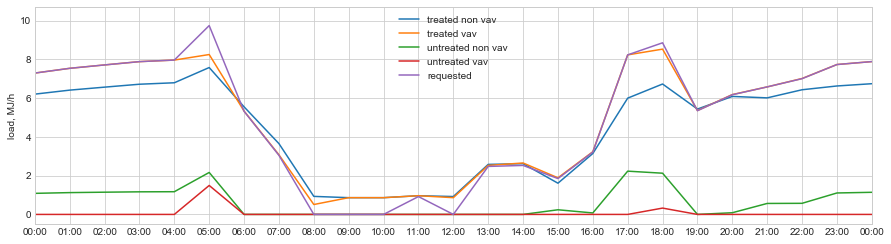

In [81]:
draw_l_d_act_h_sample_graph(0)

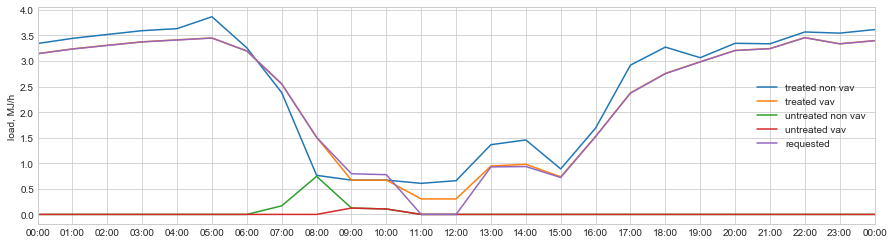

In [82]:
draw_l_d_act_h_sample_graph(1)

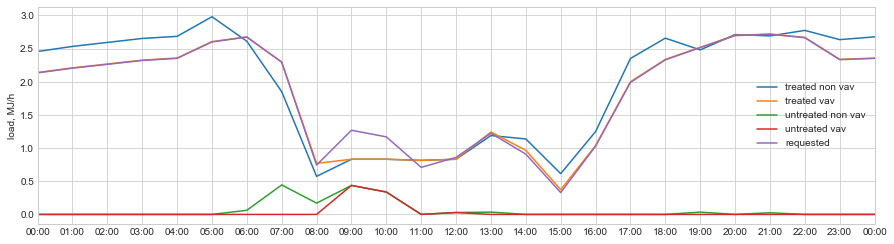

In [83]:
draw_l_d_act_h_sample_graph(2)

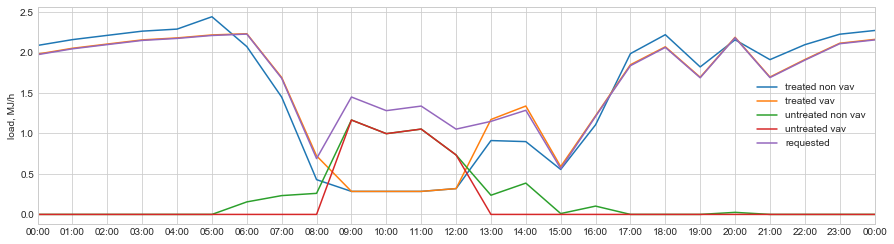

In [84]:
draw_l_d_act_h_sample_graph(3)

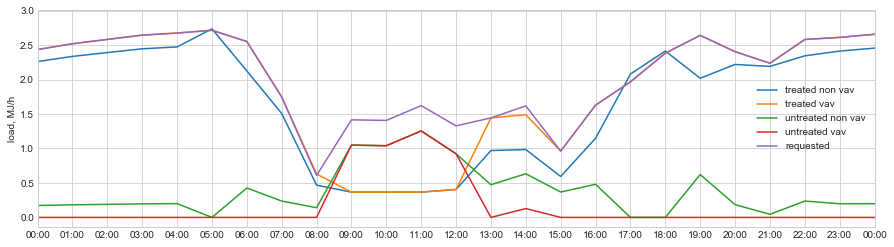

In [85]:
draw_l_d_act_h_sample_graph(4)

In [86]:
def draw_l_d_act_cs_sample_graph(rn):
    ac.draw_graph(y_title='load, MJ/h', ys=[
        (l_d_act_cs_non[rn], 'treated non vav'),
        (l_d_act_cs_vav[rn], 'treated vav'),
        (q_ut_cs_non[rn], 'untreated non vav'),
        (q_ut_cs_vav[rn], 'untreated vav'),
        (l_d_cs[rn], 'requested')
    ], op='raw', display_date=cday)

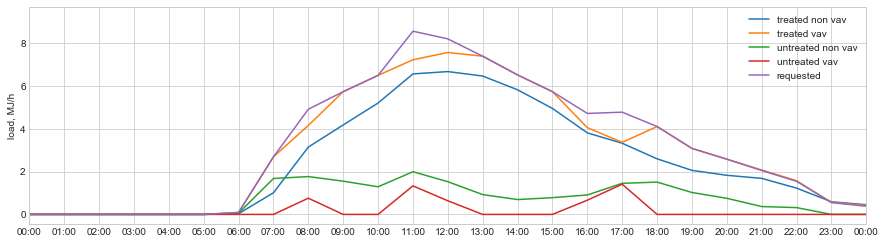

In [87]:
draw_l_d_act_cs_sample_graph(0)

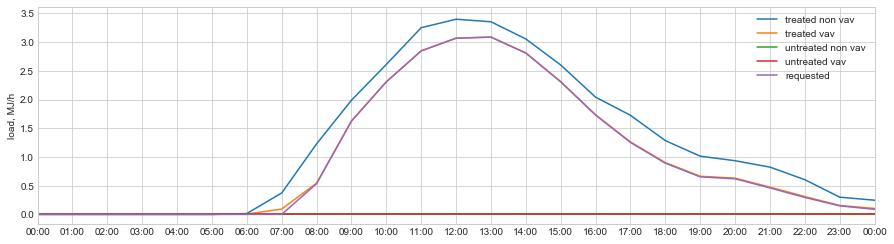

In [88]:
draw_l_d_act_cs_sample_graph(1)

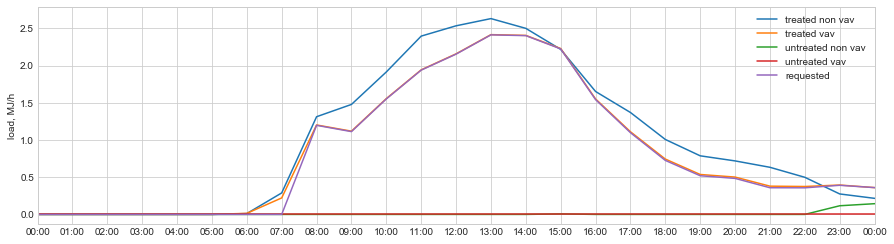

In [89]:
draw_l_d_act_cs_sample_graph(2)

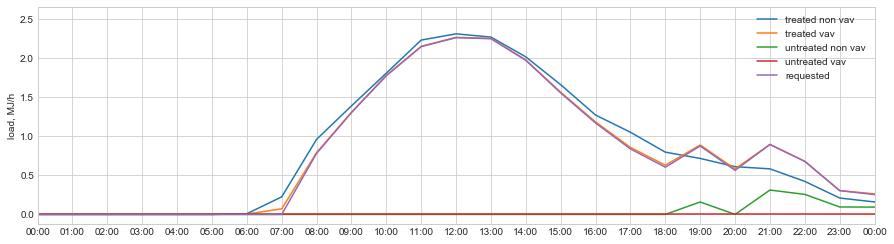

In [90]:
draw_l_d_act_cs_sample_graph(3)

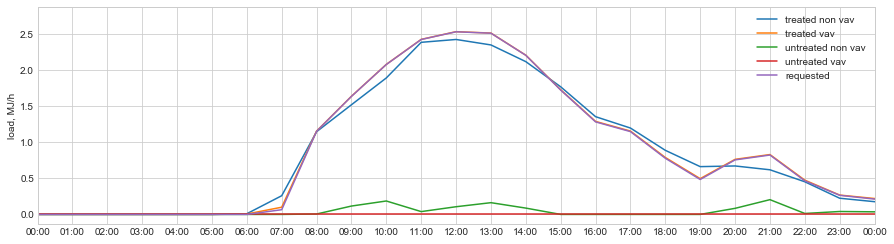

In [91]:
draw_l_d_act_cs_sample_graph(4)

In [92]:
def draw_l_d_act_cl_sample_graph(rn):
    ac.draw_graph(y_title='load, MJ/h', ys=[
        (l_d_act_cl_non[rn], 'treated non vav'),
        (l_d_act_cl_vav[rn], 'treated vav'),
        (q_ut_cl_non[rn], 'untreated non vav'),
        (q_ut_cl_vav[rn], 'untreated vav'),
        (l_d_cl[rn], 'requested')
    ], op='raw', display_date=cday)

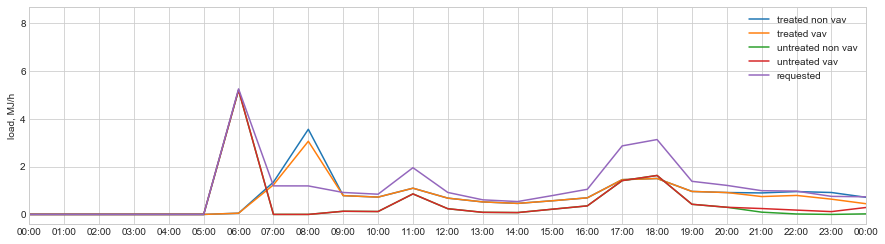

In [93]:
draw_l_d_act_cl_sample_graph(0)

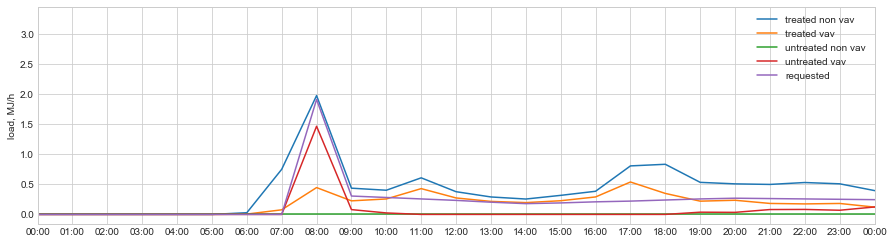

In [94]:
draw_l_d_act_cl_sample_graph(1)

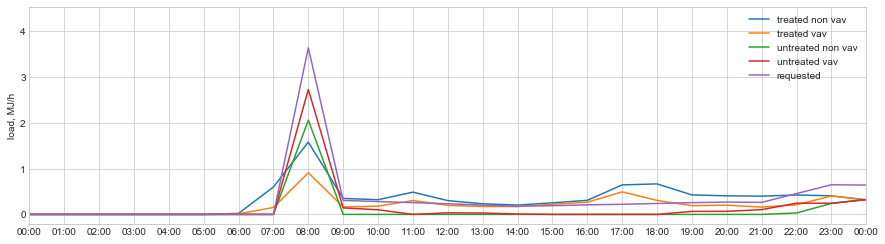

In [95]:
draw_l_d_act_cl_sample_graph(2)

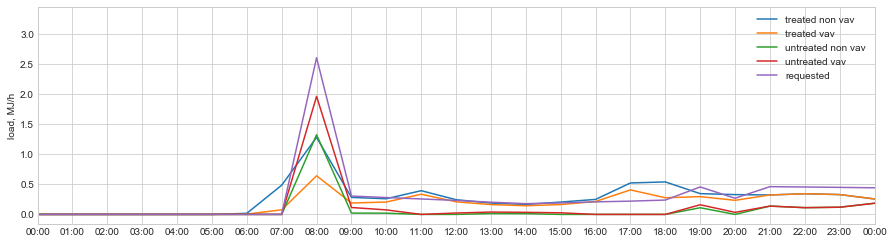

In [96]:
draw_l_d_act_cl_sample_graph(3)

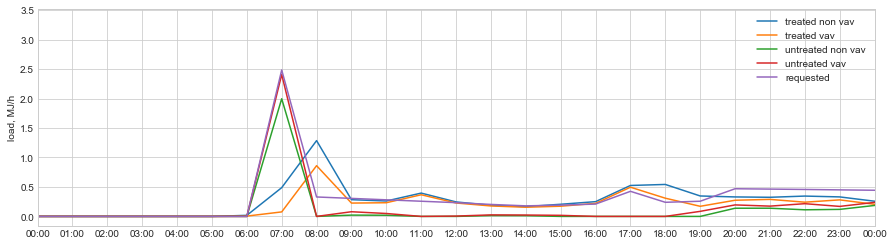

In [97]:
draw_l_d_act_cl_sample_graph(4)

## 13. 非暖冷房空間（非居室）の温度

$$ \theta_{nac,d,t} = \theta'_{nac,d,t} + \frac{ - \sum_{i=1}^5{k'_{prt,d,t,i}} (\theta_{ac,d,t} - \theta'_{nac,d,t} ) + \sum_{i=1}^5{ k_{prt,d,t,i} (\theta_{ac,act,d,t,i} - \theta'_{nac,d,t}) } }{ k_{evp,d,t} + \sum_{i=1}^5{k_{prt,d,t,i}} } $$

$$ k_{evp,d,t,i} = ( Q - 0.35 \times 0.5 \times 2.4 ) A_{NR} + c \rho \frac{V_{local,NR,d,t}}{3600} $$

$$ k_{prt,d,t,i} = c \rho \frac{V_{supply,d,t,i}}{3600} + U_{prt} A_{prrt,i} $$

$$ k'_{prt,d,t,i} = c \rho \frac{V'_{supply,d,t,i}}{3600} + U_{prt} A_{prrt,i} $$

$$ X_{nac,d,t} = X'_{nac,d,t} $$

$\theta_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房空間の温度, ℃  
$X_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房空間の絶対湿度, kg/kgDA  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$X'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の絶対湿度, kg/kgDA  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$\theta_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現温度, ℃    
$Q$：熱損失係数, W/m<sup>2</sup>K  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房室 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  

※　負荷バランス時：VAV等が導入されており、適切に負荷処理がなされ、暖冷房室の設定温度が過暖房（暖房時）又は過冷房（冷房時）になっていない場合のこと。負荷アンバランス時の場合は室温が設定温度よりも高温（暖房時）又は低温（冷房時）になる影響で非暖冷房室の温度も影響を受ける。（以下、同じ。）

In [98]:
theta_nac_non = cs.get_actual_non_occupant_room_temperature(theta_d_nac, theta_ac, theta_ac_act_non, v_supply_non, v_d_supply, v_local_nr, u_prt, a_prt, q, a_nr)
theta_nac_vav = cs.get_actual_non_occupant_room_temperature(theta_d_nac, theta_ac, theta_ac_act_vav, v_supply_vav, v_d_supply, v_local_nr, u_prt, a_prt, q, a_nr)
x_nac_non = cs.get_actual_non_occupant_room_absolute_humidity(x_d_nac)
x_nac_vav = cs.get_actual_non_occupant_room_absolute_humidity(x_d_nac)

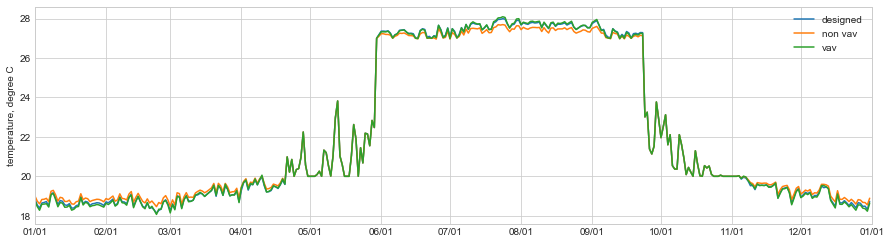

In [99]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_d_nac, 'designed'),
                  (theta_nac_non, 'non vav'),
                  (theta_nac_vav, 'vav')],
              op='ave')

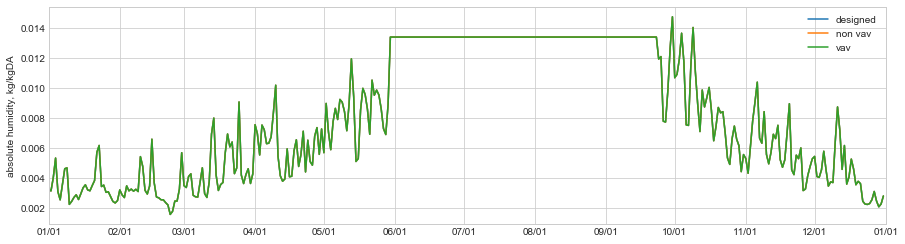

In [100]:
ac.draw_graph(y_title='absolute humidity, kg/kgDA',
              ys=[(x_d_nac, 'designed'),
                  (x_nac_non, 'non vav'),
                  (x_nac_vav, 'vav')],
              op='ave')

## 14. 非暖冷房室（非居室）の負荷（間仕切りの熱移動を含む）（参考）

「暖房運転中」

$$ L'_{act,nac,H,d,t} = \sum_{i=1}^5{\left( \theta_{ac,act,H,d,t,i} - \theta_{nac,H,d,t} \right) c \rho V_{supply,H,d,t,i} \times 10^{-6}} $$

「暖房運転中」以外

$$ L'_{act,nac,H,d,t} = 0 $$

「冷房運転中」

$$ L'_{act,nac,CS,d,t} = \sum_{i=1}^5{\left( \theta_{nac,C,d,t} - \theta_{ac,act,C,d,t,i} \right) c \rho V_{supply,C,d,t,i} \times 10^{-6}} $$

$$ L'_{act,nac,CL,d,t} = \sum_{i=1}^5{\left( X_{nac,C,d,t} - X_{ac,act,C,d,t,i} \right) L_{wtr} \rho V_{supply,C,d,t,i} \times 10^{-3}} $$

「冷房運転中」以外

$$ L'_{act,nac,CS,d,t} = 0 $$  

$$ L'_{act,nac,CL,d,t} = 0 $$

$L'_{act,nac,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房室の間仕切りの熱移動を含む実際の（※）暖房負荷, MJ/h  
$L'_{act,nac,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房室の間仕切りの熱移動を含む実際の（※）顕熱冷房負荷, MJ/h  
$L'_{act,nac,CL,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房室の実際の（※）潜熱冷房負荷, MJ/h  
$\theta_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現温度, ℃    
$\theta_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房空間の温度, ℃  
$X_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現絶対湿度, kg/kgDA    
$X_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房空間の絶対湿度, kg/kgDA  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ への吹き出し風量, m<sup>3</sup>/h  

In [101]:
l_d_act_nac_h_non = cs.get_actual_non_occupant_room_heating_load(theta_ac_act_non, theta_nac_non, v_supply_non, operation)
l_d_act_nac_h_vav = cs.get_actual_non_occupant_room_heating_load(theta_ac_act_vav, theta_nac_vav, v_supply_vav, operation)
l_d_act_nac_cs_non = cs.get_actual_non_occupant_room_sensible_cooling_load(theta_ac_act_non, theta_nac_non, v_supply_non, operation)
l_d_act_nac_cs_vav = cs.get_actual_non_occupant_room_sensible_cooling_load(theta_ac_act_vav, theta_nac_vav, v_supply_vav, operation)
l_d_act_nac_cl_non = cs.get_actual_non_occupant_room_latent_cooling_load(x_ac_act_non, x_nac_non, v_supply_non, operation)
l_d_act_nac_cl_vav = cs.get_actual_non_occupant_room_latent_cooling_load(x_ac_act_vav, x_nac_vav, v_supply_vav, operation)

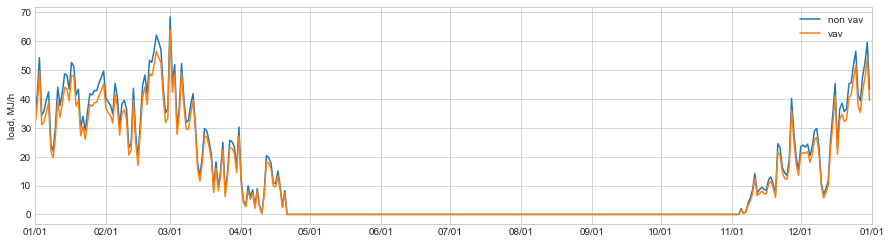

In [102]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(l_d_act_nac_h_non, 'non vav'),
                  (l_d_act_nac_h_vav, 'vav')],
              op='itg')

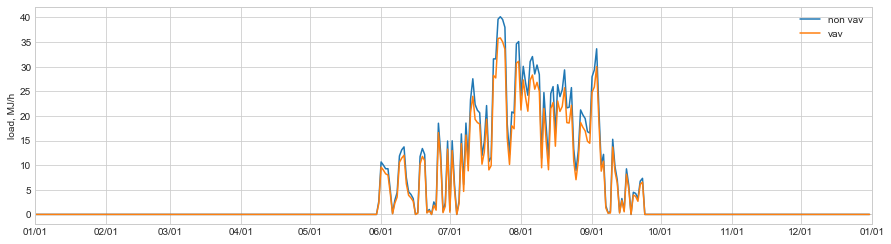

In [103]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(l_d_act_nac_cs_non, 'non vav'),
                  (l_d_act_nac_cs_vav, 'vav')],
              op='itg')

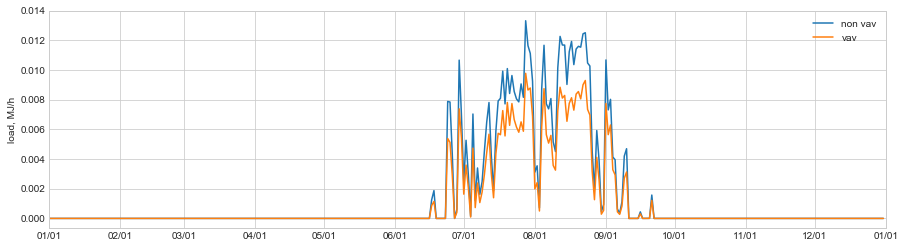

In [104]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(l_d_act_nac_cl_non, 'non vav'),
                  (l_d_act_nac_cl_vav, 'vav')],
              op='itg')

## 15. 暖冷房室（居室）と非暖冷房室（非居室）との熱移動（参考）

「暖房運転中」

$$ Q_{trs,prt,H,d,t,i} = U_{prt} A_{prt,i} \left( \theta_{ac,act,d,t,i} - \theta_{nac,H,d,t} \right) \times 3600 \times 10^{-6} $$

「暖房運転中」以外

$$ Q_{trs,prt,H,d,t,i} = 0 $$

「冷房運転中」

$$ Q_{trs,prt,C,d,t,i} = U_{prt} A_{prt,i} \left( \theta_{nac,C,d,t} - \theta_{ac,act,d,t,i} \right) \times 3600 \times 10^{-6} $$

「冷房運転中」以外

$$ Q_{trs,prt,C,d,t,i} = 0 $$

$Q_{trs,prt,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ から非暖冷房空間への貫流熱損失, MJ/h  
$Q_{trs,prt,C,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房空間から暖冷房区画 $i$ への貫流熱取得, MJ/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房室 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,act,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ の実現温度, ℃    
$\theta_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房室の温度, ℃  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  

In [105]:
q_trs_prt_h_non = cs.get_actual_heat_loss_through_partition_for_heating(u_prt, a_prt, theta_ac_act_non, theta_nac_non, operation)
q_trs_prt_h_vav = cs.get_actual_heat_loss_through_partition_for_heating(u_prt, a_prt, theta_ac_act_vav, theta_nac_vav, operation)
q_trs_prt_c_non = cs.get_actual_heat_gain_through_partition_for_cooling(u_prt, a_prt, theta_ac_act_non, theta_nac_non, operation)
q_trs_prt_c_vav = cs.get_actual_heat_gain_through_partition_for_cooling(u_prt, a_prt, theta_ac_act_vav, theta_nac_vav, operation)

## 16. 熱源機入り口温度

$$ \theta_{hs,in,d,t} = \theta_{nac,d,t} $$

$$ X_{hs,in,d,t} = X_{nac,d,t} $$

$\theta_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機入り口温度, ℃  
$X_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機入り口絶対湿度, kg/kgDA  
$\theta_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房室の温度, ℃  
$X_{nac,d,t}$：日付 $d$ の時刻 $t$ における非暖冷房室の絶対湿度, kg/kgDA  

In [106]:
theta_hs_in_non = cs.get_heat_source_inlet_air_temperature(theta_nac_non)
theta_hs_in_vav = cs.get_heat_source_inlet_air_temperature(theta_nac_vav)
x_hs_in_non = cs.get_heat_source_inlet_air_absolute_humidity(x_nac_non)
x_hs_in_vav = cs.get_heat_source_inlet_air_absolute_humidity(x_nac_vav)

## 17. 熱源機処理熱量（参考）

「暖房運転中」

$$ Q_{hs,H,d,t} = \left( \theta_{hs,out,H,d,t} - \theta_{hs,in,d,t} \right) c \rho \sum_{i=1}^5{V_{supply,d,t,i}} \times 10^{-6} $$

「暖房運転中」以外

$$ Q_{hs,H,d,t} = 0 $$

「冷房運転中」

$$ Q_{hs,CS,d,t} = \left( \theta_{hs,in,d,t} - \theta_{hs,out,C,d,t} \right) c \rho \sum_{i=1}^5{V_{supply,d,t,i}} \times 10^{-6} $$

$$ Q_{hs,CL,d,t} = \left( X_{hs,in,d,t} - X_{hs,out,C,d,t} \right) L_{wtr} \rho \sum_{i=1}^5{V_{supply,d,t,i}} \times 10^{-3} $$ 

「冷房運転中」以外

$$ Q_{hs,CS,d,t} = 0 $$

$$ Q_{hs,CL,d,t} = 0 $$

$Q_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の暖房出力, MJ/h  
$Q_{hs,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房顕熱出力, MJ/h  
$Q_{hs,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房潜熱出力, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口絶対湿度, ℃  
$\theta_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機の入口空気温度, ℃  
$X_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機の入口絶対湿度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$L_{wtr}$：水の蒸発潜熱, kJ/kg
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ への吹き出し風量, m<sup>3</sup>/h  

In [107]:
q_hs_h_non = cs.get_heat_source_heating_output(theta_hs_out_h_non, theta_hs_in_non, v_supply_non, operation)
q_hs_h_vav = cs.get_heat_source_heating_output(theta_hs_out_h_vav, theta_hs_in_vav, v_supply_vav, operation)
q_hs_cs_non, q_hs_cl_non = cs.get_heat_source_cooling_output(
    theta_hs_in_non, x_hs_in_non, theta_hs_out_c_non, x_hs_out_c_non, v_supply_non, operation)
q_hs_cs_vav, q_hs_cl_vav = cs.get_heat_source_cooling_output(
    theta_hs_in_vav, x_hs_in_vav, theta_hs_out_c_vav, x_hs_out_c_vav, v_supply_vav, operation)

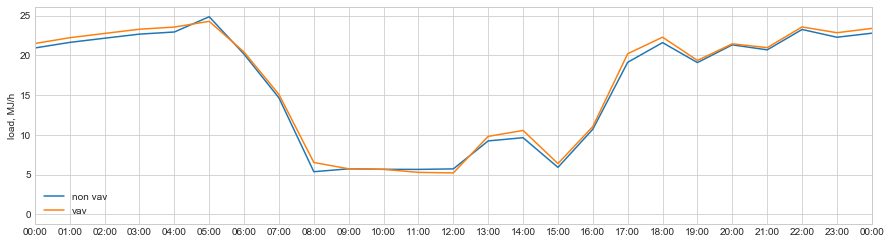

In [108]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(q_hs_h_non, 'non vav'),
                  (q_hs_h_vav, 'vav')],
              op='raw', display_date=hday)

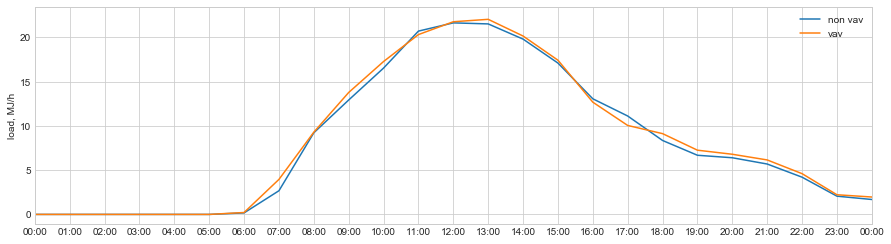

In [109]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(q_hs_cs_non, 'non vav'),
                  (q_hs_cs_vav, 'vav')],
              op='raw', display_date=cday)

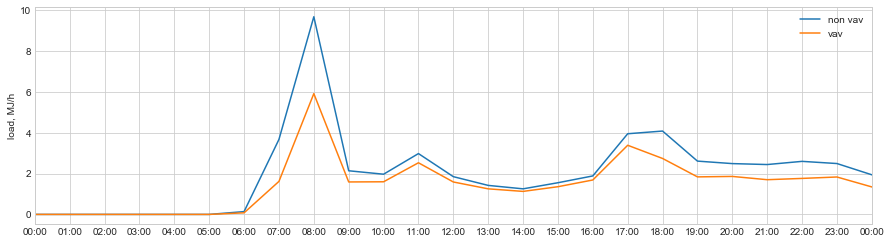

In [110]:
ac.draw_graph(y_title='load, MJ/h',
              ys=[(q_hs_cl_non, 'non vav'),
                  (q_hs_cl_vav, 'vav')],
              op='raw', display_date=cday)

## 18. 外部モジュールへの引き渡し

本モジュールを外部のモジュールから呼び出して必要な値を取得する場合に利用する関数を定義します。

In [111]:
def get_heat(
    region, a_a, a_hcz, u_prt, a_prt, q, a_nr, q_rtd_h, q_rtd_c,
    theta_sat, theta_ac, x_ac, is_duct_insulated, theta_d_nac, x_d_nac, vav_system,
    hc_period, l_d_h, l_d_cs, l_d_cl, v_d_supply, v_vent, v_local_nr):
    
    # operation (8760 times) h = heating operation, c = cooling operation, n = non operation
    operation = cs.get_operation(l_d_h, l_d_cs)
    
    # duct liner heat loss coefficient, W/mK
    psi = cs.get_duct_linear_heat_loss_coefficient()

    # duct length in the standard house, m, ((5 rooms), (5 rooms), (5 rooms))
    l_duct_in_r, l_duct_ex_r, l_duct_r = cs.get_standard_house_duct_length()

    # duct length for each room, m, (5 rooms)
    l_duct = cs.get_duct_length(l_duct_r=l_duct_r, a_a=a_a)

    # attic temperature, degree C, (8760 times)
    theta_attic = cs.get_attic_temperature(theta_sat, theta_ac)

    # duct ambient temperature, degree C, (5 rooms * 8760 times)
    theta_sur = cs.get_duct_ambient_air_temperature(is_duct_insulated, l_duct_in_r, l_duct_ex_r, theta_ac, theta_attic)

    # inlet air temperature of heat source,degree C, (8760 times)
    theta_d_hs_in, x_d_hs_in = cs.get_heat_source_inlet_air_balanced(theta_d_nac, x_d_nac)

    # maximum heating and cooling output, MJ/h (8760 times)
    q_hs_max_h = cs.get_heat_source_maximum_heating_output(region, q_rtd_h)
    q_hs_max_cs, q_hs_max_cl = cs.get_heat_source_maximum_cooling_output(q_rtd_c, l_d_cs, l_d_cl)

    # maximum and minimum temperature and absolute humidity when maximum output of heat sourace
    theta_hs_out_max_h = cs.get_theta_hs_out_max_h(theta_d_hs_in, q_hs_max_h, v_d_supply)
    theta_hs_out_min_c = cs.get_theta_hs_out_min_c(theta_d_hs_in, q_hs_max_cs, v_d_supply)
    x_hs_out_min_c = cs.get_x_hs_out_min_c(x_d_hs_in, q_hs_max_cl, v_d_supply)

    # requested supply air temperature, degree C, (5 rooms * 8760 times)
    theta_req_h = cs.get_requested_supply_air_temperature_for_heating(
        theta_sur, theta_ac, l_d_h, v_d_supply, psi, l_duct)
    theta_req_c = cs.get_requested_supply_air_temperature_for_cooling(
        theta_sur, theta_ac, l_d_cs, v_d_supply, psi, l_duct)
    x_req_c = cs.get_requested_supply_air_absolute_humidity_for_cooling(x_ac, l_d_cl, v_d_supply)

    # outlet temperature of heat source, degree C, (8760 times)
    theta_hs_out_h = cs.get_decided_outlet_supply_air_temperature_for_heating(
        vav_system, theta_req_h, v_d_supply, theta_hs_out_max_h)
    theta_hs_out_c = cs.get_decided_outlet_supply_air_temperature_for_cooling(
        vav_system, theta_req_c, v_d_supply, theta_hs_out_min_c)

    # supply air volume for each room for heating, m3/h, (5 rooms * 8760 times)
    v_supply = cs.get_each_supply_air_volume(
        hc_period, vav_system, l_d_h, l_d_cs, theta_hs_out_h, theta_hs_out_c, theta_sur,
        psi, l_duct, theta_ac, v_vent, v_d_supply, operation)

    # outlet absolute humidity of heat source, kg/kgDA (8760 times)
    x_hs_out_c = cs.get_decided_outlet_supply_air_absolute_humidity_for_cooling(x_req_c, v_supply, x_hs_out_min_c)

    # supply air temperature, degree C (5 rooms * 8760 times)
    theta_supply_h = cs.get_supply_air_temperature_for_heating(theta_sur, theta_hs_out_h, psi, l_duct, v_supply, theta_ac, operation)
    # supply air temperature, degree C (5 rooms * 8760 times)
    theta_supply_c = cs.get_supply_air_temperature_for_cooling(theta_sur, theta_hs_out_c, psi, l_duct, v_supply, theta_ac, operation)
    # supply air absolute humidity, kg/kgDA (5 rooms * 8760 times)
    x_supply_c = cs.get_supply_air_absolute_humidity_for_cooling(x_hs_out_c, x_ac, operation)

    # actual air conditioned temperature, degree C, (5 rooms * 8760 times)
    theta_ac_act = cs.get_actual_air_conditioned_temperature(
        hc_period, theta_ac, v_supply, theta_supply_h, theta_supply_c,
        l_d_h, l_d_cs, u_prt, a_prt, a_hcz, q)

    # actual air conditioned absolute humidity, kg/kgDA (5 rooms * 8760 times)
    x_ac_act = cs.get_actual_air_conditioned_absolute_humidity(x_ac)

    # actual treated load for heating, MJ/h, (5 rooms * 8760 times)
    l_d_act_h = cs.get_actual_treated_heating_load(hc_period, theta_supply_h, theta_ac_act, v_supply)
    l_d_act_cs = cs.get_actual_treated_sensible_cooling_load(hc_period, theta_supply_c, theta_ac_act, v_supply)
    l_d_act_cl = cs.get_actual_treated_latent_cooling_load(hc_period, x_supply_c, x_ac_act, v_supply)

    # untreated load, MJ/h, (5 rooms * 8760 times, 5 rooms * 8760 times, 5 rooms * 8760 times)
    q_ut_h, q_ut_cs, q_ut_cl = cs.get_untreated_load(
        l_d_act_h, l_d_h, l_d_act_cs, l_d_cs, l_d_act_cl, l_d_cl)

    # actual non occupant room temperature, degree C, (8760 times)
    theta_nac = cs.get_actual_non_occupant_room_temperature(
        theta_d_nac, theta_ac, theta_ac_act, v_supply, v_d_supply, v_local_nr, u_prt, a_prt, q, a_nr)
    # actual non occupant room absolute humidity, kg/kgDA, (8760 times)
    x_nac = cs.get_actual_non_occupant_room_absolute_humidity(x_d_nac)

    # inlet air temperature of heat source,degree C, (8760 times)
    theta_hs_in = cs.get_heat_source_inlet_air_temperature(theta_nac)
    # inlet air absolute humidity of heat source, kg/kgDA (8760 times)
    x_hs_in = cs.get_heat_source_inlet_air_absolute_humidity(x_nac)
    
    return theta_hs_in, x_hs_in, theta_hs_out_h, theta_hs_out_c, x_hs_out_c, v_supply, operation

In [112]:
get_heat(
    case['region'], a_a, a_hcz, u_prt, a_prt, q, a_nr, q_rtd_h, q_rtd_c,
    theta_sat, theta_ac, x_ac, is_duct_insulated, theta_d_nac, x_d_nac, vav_system,
    hc_period, l_d_h, l_d_cs, l_d_cl, v_d_supply, v_vent, v_local_nr)

(array([18.5240316 , 18.50963642, 18.51046802, ..., 18.415953  ,
        17.87536822, 18.67745285]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([30.13211912, 30.24083678, 30.20715332, ..., 29.65611796,
        31.22999636, 28.9962581 ]),
 array([20., 20., 20., ..., 20., 20., 20.]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([[468.11565231, 460.46390045, 463.0144844 , ..., 416.81045706,
         430.28097496, 519.46598863],
        [260.04680316, 255.79611511, 257.21301113, ..., 231.54582922,
         239.02894818, 288.5728538 ],
        [208.06884915, 204.66778534, 205.80147328, ..., 185.26462785,
         191.25202678, 230.89313483],
        [168.96760882, 166.20568832, 167.12632849, ..., 150.44886005,
         155.31107986, 187.50265138],
        [169.12464191, 166.36015458, 167.28165035, ..., 150.58868241,
         155.45542101, 187.67691035]]),
 array(['h', 'h', 'h', ..., 'h', 'h', 'h'], dtype='<U1'))